In [54]:
import covsirphy as cs

In [55]:
from datetime import datetime
time_format = "%d%b%Y %H:%M"
datetime.now().strftime(time_format)

'31May2020 17:32'

In [56]:
from collections import defaultdict
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import functools
from IPython.display import display, Markdown
import math
import os
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import numpy as np
import pandas as pd
import dask.dataframe as dd
pd.plotting.register_matplotlib_converters()
import seaborn as sns
import scipy as sci
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import sympy as sym

In [57]:
np.random.seed(123)
os.environ["PYTHONHASHSEED"] = "123"
# Matplotlib
plt.style.use("seaborn-ticks")
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["font.size"] = 11.0
plt.rcParams["figure.figsize"] = (9, 6)
# Pandas
pd.set_option("display.max_colwidth", 1000)

In [58]:
pop_data = cs.Population(
    r"C:\Users\alshrooq\Desktop\NasaData\covid19-global-forecasting-locations-population\locations_population.csv"
)
pop_data.cleaned().tail()

Country Province  Population
335             Vietnam        -    95540000
336  West Bank and Gaza        -     4776131
337      Western Sahara        -      593611
338              Zambia        -    17090000
339            Zimbabwe        -    16530000

In [59]:
pyramid_csv_list = list()
for dirname, _, filenames in os.walk(r"C:\Users\alshrooq\Desktop\NasaData\population-pyramid-2019"):
    for filename in filenames:
        name = os.path.join(dirname, filename)
        df = pd.read_csv(name)
        df["Country"], df["Year"], _ = filename.replace(".", "-").split("-")
        pyramid_csv_list.append(df)
pyramid_raw = pd.concat(pyramid_csv_list, sort=True)
pyramid_raw.head()

Age Country        F        M  Year
0    0-4  Canada   965981  1013876  2019
1    5-9  Canada   967470  1012761  2019
2  10-14  Canada   961187  1006817  2019
3  15-19  Canada   978597  1027473  2019
4  20-24  Canada  1176141  1231211  2019

In [60]:
pyramid_raw["Country"].unique()

array(['Canada', 'China', 'France', 'Germany', 'India', 'Iran', 'Italy',
       'Japan', 'Spain', 'United Kingdom', 'United States of America'],
      dtype=object)

In [61]:
df = pyramid_raw.copy()
df["Country"] = df["Country"].replace(
    {
        "United States of America": "US",
        "United Kingdom": "UK",
    }
)
# Global (WORLD)
_male = [
    349432556, 342927576, 331497486, 316642222, 308286775, 306059387, 309236984,
    276447037, 249389688, 241232876, 222609691, 192215395, 157180267, 128939392,
    87185982, 54754941, 33648953, 15756942, 5327866, 1077791, 124144
]
_female = [
    328509234, 321511867, 309769906, 295553758, 289100903, 288632766, 296293748,
    268371754, 244399176, 238133281, 223162982, 195633743, 164961323, 140704320,
    101491347, 69026831, 48281201, 26429329, 11352182, 3055845, 449279
]
_df = pd.DataFrame(
    {
        "Age": df["Age"].unique(),
        "Country": "Global",
        "F": _female,
        "M": _male,
        "Year": 2019
    }
)
df = pd.concat([df, _df], axis=0, ignore_index=True, sort=True)
# Sweden
_male = [
    307116, 304759, 296771, 270840, 291723, 376952, 343311, 315086,
    312017, 336452, 342117, 306949, 279609, 265511, 273061, 195029,
    113166, 61775, 26170, 6768, 415
]
_female = [
    290553, 288817, 280944, 257677, 274760, 361526, 330153, 300752,
    301288, 327453, 331458, 300084, 280009, 272149, 286879, 212480,
    143654, 97633, 52624, 18130, 1771
]
_df = pd.DataFrame(
    {
        "Age": df["Age"].unique(),
        "Country": "Sweden",
        "F": _female,
        "M": _male,
        "Year": 2019
    }
)
df = pd.concat([df, _df], axis=0, ignore_index=True, sort=True)
# Philippines
_male = [
    5534962, 5820604, 5538414, 5383822, 5149849, 4710777, 4061897, 3581091, 3237426,
    2832825, 2482953, 2015857, 1556935, 1082875, 668107, 364200, 199400, 73508,
    17327, 3035, 208
]
_female = [
    5240508, 5541514, 5273495, 5029137, 4896316, 4589506, 3982681,
    3544279, 3191565, 2825286, 2521463, 2112380, 1714689, 1285782,
    895866, 567282, 360751, 155294, 57969, 13376, 1411
]
_df = pd.DataFrame(
    {
        "Age": df["Age"].unique(),
        "Country": "Philippines",
        "F": _female,
        "M": _male,
        "Year": 2019
    }
)
df = pd.concat([df, _df], axis=0, ignore_index=True, sort=True)
# Arrange
df["Population"] = df["F"] + df["M"]
df = df.pivot_table(
    index="Age", columns=["Country"], values="Population", aggfunc="last"
)
df = df.astype(np.int64).reset_index().rename({"Age": "Age_bin"}, axis=1)
series = df["Age_bin"].str.replace("+", "-122")
df[["Age_first", "Age_last"]] = series.str.split("-", expand=True).astype(np.int64)
df = df.drop("Age_bin", axis=1)
series = df["Age_last"]
df = df.apply(lambda x: x[:-2] / (x[-1] - x[-2] + 1), axis=1)
df["Age"] = series
df = pd.merge(df, pd.DataFrame({"Age": np.arange(0, 123, 1)}), on="Age", how="right", sort=True)
df = df.fillna(method="bfill").astype(np.int64)
df = df.set_index("Age")
pyramid_df = df.copy()
pyramid_df

Canada     China  France  Germany     Global     India     Iran   Italy  \
Age                                                                            
0    395971  17008206  733844   797488  135588358  23356364  1516560  476509   
1    395971  17008206  733844   797488  135588358  23356364  1516560  476509   
2    395971  17008206  733844   797488  135588358  23356364  1516560  476509   
3    395971  17008206  733844   797488  135588358  23356364  1516560  476509   
4    395971  17008206  733844   797488  135588358  23356364  1516560  476509   
5    396046  17308959  787481   747894  132887888  23990001  1358879  544206   
6    396046  17308959  787481   747894  132887888  23990001  1358879  544206   
7    396046  17308959  787481   747894  132887888  23990001  1358879  544206   
8    396046  17308959  787481   747894  132887888  23990001  1358879  544206   
9    396046  17308959  787481   747894  132887888  23990001  1358879  544206   
10   393600  16738429  797550   759613  128253478  25396982  1212998  573762   
11   393600  16738429  797550   759613  128253478  25396982  1212998  573762   
12   393600  16738429  797550   759613  128253478  25396982  1212998  573762   
13   393600  16738429  797550   759613  128253478  25396982  1212998  573762   
14   393600  16738429  797550   759613  128253478  25396982  1212998  573762   
15   401214  16564312  773860   830071  122439196  25137885  1093252  574303   
16   401214  16564312  773860   830071  122439196  25137885  1093252  574303   
17   401214  16564312  773860   830071  122439196  25137885  1093252  574303   
18   401214  16564312  773860   830071  122439196  25137885  1093252  574303   
19   401214  16564312  773860   830071  122439196  25137885  1093252  574303   
20   481470  17715284  739703   910269  119477535  24359467  1145239  591064   
21   481470  17715284  739703   910269  119477535  24359467  1145239  591064   
22   481470  17715284  739703   910269  119477535  24359467  1145239  591064   
23   481470  17715284  739703   910269  119477535  24359467  1145239  591064   
24   481470  17715284  739703   910269  119477535  24359467  1145239  591064   
25   540606  20862923  743386   974062  118938430  23336824  1431838  635981   
26   540606  20862923  743386   974062  118938430  23336824  1431838  635981   
27   540606  20862923  743386   974062  118938430  23336824  1431838  635981   
28   540606  20862923  743386   974062  118938430  23336824  1431838  635981   
29   540606  20862923  743386   974062  118938430  23336824  1431838  635981   
..      ...       ...     ...      ...        ...       ...      ...     ...   
93    50061    454974  131118   149975    3336009    207618    11407  126951   
94    50061    454974  131118   149975    3336009    207618    11407  126951   
95    15115    105386   42881    42278     826727     49492     2306   37688   
96    15115    105386   42881    42278     826727     49492     2306   37688   
97    15115    105386   42881    42278     826727     49492     2306   37688   
98    15115    105386   42881    42278     826727     49492     2306   37688   
99    15115    105386   42881    42278     826727     49492     2306   37688   
100     352      2949     808      769      24931      1947       21     694   
101     352      2949     808      769      24931      1947       21     694   
102     352      2949     808      769      24931      1947       21     694   
103     352      2949     808      769      24931      1947       21     694   
104     352      2949     808      769      24931      1947       21     694   
105     352      2949     808      769      24931      1947       21     694   
106     352      2949     808      769      24931      1947       21     694   
107     352      2949     808      769      24931      1947       21     694   
108     352      2949     808      769      24931      1947       21     694   
109     352      2949     808      769      24931      1947       21     694   
110  

In [62]:
_period_of_life_list = [
    "nursery", "nursery school", "elementary school", "middle school",
    "high school", "university/work", "work", "work", "work", "work",
    "retired", "retired", "retired"
]
df = pd.DataFrame(
    {
        "Age_first": [0, 3, 6, 11, 14, 19, 26, 36, 46, 56, 66, 76, 86],
        "Age_last": [2, 5, 10, 13, 18, 25, 35, 45, 55, 65, 75, 85, 95],
        "Period_of_life": _period_of_life_list,
        "Days": [3, 5, 6, 6, 7, 7, 6, 5, 5, 5, 4, 3, 2]
    }
)

df["Types"] = df["Period_of_life"].replace(
    {
        "nursery": "school",
        "nursery school": "school",
        "elementary school": "school",
        "middle school": "school",
        "high school": "school",
        "university/work": "school/work"
    }
)
df["School"] = df[["Types", "Days"]].apply(lambda x: x[1] if "school" in x[0] else 0, axis=1)
df["Office"] = df[["Types", "Days"]].apply(lambda x: x[1] if "work" in x[0] else 0, axis=1)
df["Others"] = df["Days"] - df[["School", "Office"]].sum(axis=1)
df.loc[df["Others"] < 0, "Others"] = 0
df.loc[df.index[1:5], "School"] -= 1
df.loc[df.index[1:5], "Others"] += 1
df.loc[df.index[5], ["School", "Office", "Others"]] = [3, 3, 1]
df[["School", "Office", "Others"]] = df[["Days", "School", "Office", "Others"]].apply(
    lambda x: x[1:] / sum(x[1:]) * x[0], axis=1
).astype(np.int64)
df.loc[df.index[6:10], "Others"] += 1
df = df.drop(["Days", "Types"], axis=1)

_out_df = df.copy()
_out_df

Age_first  Age_last     Period_of_life  School  Office  Others
0           0         2            nursery       3       0       0
1           3         5     nursery school       4       0       1
2           6        10  elementary school       5       0       1
3          11        13      middle school       5       0       1
4          14        18        high school       6       0       1
5          19        25    university/work       3       3       1
6          26        35               work       0       6       1
7          36        45               work       0       5       1
8          46        55               work       0       5       1
9          56        65               work       0       5       1
10         66        75            retired       0       0       4
11         76        85            retired       0       0       3
12         86        95            retired       0       0       2

In [63]:
df = pyramid_df.cumsum()
countries = df.columns[:]
df = pd.merge(_out_df, df, left_on="Age_last", right_on="Age", how="left")
_first = df.loc[df.index[0], countries]
df[countries] = df[countries].diff()
df.loc[df.index[0], countries] = _first
df[countries] = df[countries].apply(lambda x: x / x.sum(), axis=0)
out_df = df.copy()
out_df

Age_first  Age_last     Period_of_life  School  Office  Others    Canada  \
0           0         2            nursery       3       0       0  0.031811   
1           3         5     nursery school       4       0       1  0.031813   
2           6        10  elementary school       5       0       1  0.052963   
3          11        13      middle school       5       0       1  0.031621   
4          14        18        high school       6       0       1  0.053517   
5          19        25    university/work       3       3       1  0.089688   
6          26        35               work       0       6       1  0.141335   
7          36        45               work       0       5       1  0.133597   
8          46        55               work       0       5       1  0.132237   
9          56        65               work       0       5       1  0.137679   
10         66        75            retired       0       0       4  0.097153   
11         76        85            retired       0       0       3  0.048571   
12         86        95            retired       0       0       2  0.018014   

       China    France   Germany    Global     India      Iran     Italy  \
0   0.035600  0.033901  0.028711  0.052210  0.051289  0.054879  0.023674   
1   0.035809  0.034727  0.028115  0.051864  0.051752  0.052977  0.024795   
2   0.059984  0.060787  0.045016  0.084689  0.088830  0.080195  0.045552   
3   0.035035  0.036844  0.027347  0.049386  0.055770  0.043894  0.028506   
4   0.057906  0.059948  0.048961  0.079324  0.092191  0.067379  0.047546   
5   0.087912  0.080317  0.076269  0.107659  0.124634  0.099528  0.068986   
6   0.160417  0.119402  0.124868  0.152774  0.164456  0.192333  0.110560   
7   0.140662  0.124751  0.123987  0.131630  0.135250  0.163720  0.137011   
8   0.166102  0.134609  0.150438  0.116396  0.103354  0.110998  0.161104   
9   0.116123  0.124850  0.143657  0.088096  0.074217  0.075731  0.135972   
10  0.072307  0.105084  0.099964  0.055083  0.040285  0.038935  0.110518   
11  0.026368  0.057846  0.078264  0.024309  0.015153  0.015988  0.076720   
12  0.005775  0.026933  0.024405  0.006579  0.002821  0.003443  0.029057   

       Japan  Philippines     Spain    Sweden        UK        US  
0   0.023292     0.059807  0.025943  0.035809  0.035174  0.035813  
1   0.024166     0.060893  0.027265  0.035727  0.035658  0.036229  
2   0.043395     0.104088  0.050480  0.058956  0.060363  0.062293  
3   0.026526     0.060010  0.031812  0.034614  0.034583  0.038632  
4   0.045251     0.097064  0.048522  0.053759  0.055262  0.064638  
5   0.066696     0.129404  0.068295  0.081871  0.085452  0.095708  
6   0.106875     0.156425  0.113973  0.138543  0.136443  0.139912  
7   0.134815     0.122671  0.162583  0.123699  0.129938  0.125441  
8   0.142129     0.095804  0.158071  0.132422  0.134289  0.125788  
9   0.123395     0.065197  0.128555  0.115113  0.119465  0.125640  
10  0.137152     0.033720  0.094637  0.107004  0.096797  0.089943  
11  0.089784     0.012498  0.061907  0.061383  0.056187  0.043898  
12  0.036524     0.002420  0.027957  0.021099  0.020388  0.016066

In [64]:
def go_out(country, out_df=out_df):
    """
    Return the estimated number of days people usually go out.
    @country <str>: coutry name
    @out_df <pd.DataFrame>: template dataframe
    """
    df = out_df.copy()
    try:
        series = df[country]
    except KeyError:
        raise KeyError(f"Population pyramid data of {country} is not defined!")
    df = df.iloc[:, :6]
    df["Portion"] = series
    return df

In [65]:
go_out("Global")

Age_first  Age_last     Period_of_life  School  Office  Others   Portion
0           0         2            nursery       3       0       0  0.052210
1           3         5     nursery school       4       0       1  0.051864
2           6        10  elementary school       5       0       1  0.084689
3          11        13      middle school       5       0       1  0.049386
4          14        18        high school       6       0       1  0.079324
5          19        25    university/work       3       3       1  0.107659
6          26        35               work       0       6       1  0.152774
7          36        45               work       0       5       1  0.131630
8          46        55               work       0       5       1  0.116396
9          56        65               work       0       5       1  0.088096
10         66        75            retired       0       0       4  0.055083
11         76        85            retired       0       0       3  0.024309
12         86        95            retired       0       0       2  0.006579

In [66]:
jhu_data = cs.JHUData(r"C:\Users\alshrooq\Desktop\NasaData\novel-corona-virus-2019-dataset\covid_19_data.csv")
ncov_df = jhu_data.cleaned()
ncov_df.tail()

Date Country   Province  Confirmed  Infected  Fatal  Recovered
30878 2020-05-28  Mexico    Yucatan       1661       403    139       1119
30879 2020-05-28  Canada      Yukon         11         0      0         11
30880 2020-05-28   China     Yunnan        185         0      2        183
30881 2020-05-28  Mexico  Zacatecas        272        59     31        182
30882 2020-05-28   China   Zhejiang       1268         0      1       1267

In [67]:
jhu_first_date, jhu_last_date = ncov_df["Date"].min(), ncov_df["Date"].max()
jhu_elapsed = (jhu_last_date - jhu_first_date).days
print(f"{jhu_elapsed} days have passed from the date of the first record.")

127 days have passed from the date of the first record.


In [68]:
jpn_data = cs.CountryData(r"C:\Users\alshrooq\Desktop\NasaData\covid19-dataset-in-japan\covid_jpn_total.csv", country="Japan")
jpn_data.set_variables(
    date="Date", confirmed="Positive", fatal="Fatal", recovered="Discharged", province=None
)
jpn_data.cleaned().tail()

Date Country Province  Confirmed  Infected  Fatal  Recovered
104 2020-05-25   Japan        -      16581      2139    830      13612
105 2020-05-26   Japan        -      16623      1967    846      13810
106 2020-05-27   Japan        -      16651      1820    858      13973
107 2020-05-28   Japan        -      16683      1669    867      14147
108 2020-05-29   Japan        -      16719      1591    874      14254

In [69]:
jhu_data.replace(jpn_data)
ncov_df = jhu_data.cleaned()
ncov_df.tail()

Date Country Province  Confirmed  Infected  Fatal  Recovered
104 2020-05-25   Japan        -      16581      2139    830      13612
105 2020-05-26   Japan        -      16623      1967    846      13810
106 2020-05-27   Japan        -      16651      1820    858      13973
107 2020-05-28   Japan        -      16683      1669    867      14147
108 2020-05-29   Japan        -      16719      1591    874      14254

In [70]:
data_cols = ["Infected", "Fatal", "Recovered"]
rate_cols = ["Fatal per Confirmed", "Recovered per Confirmed", "Fatal per (Fatal or Recovered)"]
total_df = jhu_data.total()
total_df = total_df.loc[total_df.index <= jhu_last_date, :]
total_df.tail()

Confirmed  Infected   Fatal  Recovered  Fatal per Confirmed  \
Date                                                                      
2020-05-24    5407613   2893842  345059    2168712             0.063810   
2020-05-25    5495061   2917091  346232    2231738             0.063008   
2020-05-26    5589626   2952217  350453    2286956             0.062697   
2020-05-27    5691790   2986073  355629    2350088             0.062481   
2020-05-28    5809031   3032726  360294    2416011             0.062023   

            Recovered per Confirmed  Fatal per (Fatal or Recovered)  
Date                                                                 
2020-05-24                 0.401048                        0.137267  
2020-05-25                 0.406135                        0.134304  
2020-05-26                 0.409143                        0.132878  
2020-05-27                 0.412891                        0.131436  
2020-05-28                 0.415906                        0.129775

In [71]:
cs.line_plot(total_df[data_cols], "Total number of cases over time")

In [72]:
cs.line_plot(total_df[rate_cols], "Global rate over time", ylabel="", math_scale=False)

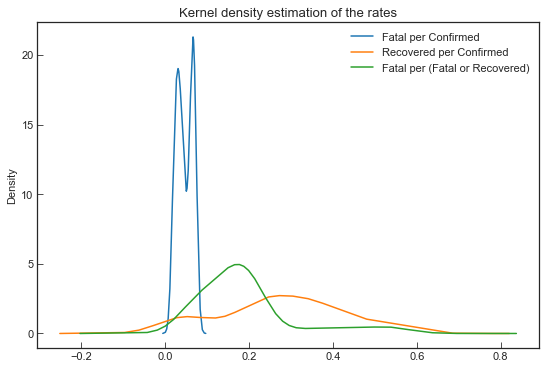

In [73]:
total_df[rate_cols].plot.kde()
plt.title("Kernel density estimation of the rates")
plt.show()

In [74]:
total_df[rate_cols].describe().T

count      mean       std       min       25%  \
Fatal per Confirmed             128.0  0.047282  0.018085  0.020424  0.031276   
Recovered per Confirmed         128.0  0.277103  0.145337  0.017267  0.206803   
Fatal per (Fatal or Recovered)  128.0  0.188966  0.114765  0.057462  0.123641   

                                     50%       75%       max  
Fatal per Confirmed             0.045285  0.066438  0.071656  
Recovered per Confirmed         0.282502  0.372466  0.552893  
Fatal per (Fatal or Recovered)  0.172717  0.209238  0.577465

In [75]:
linelist_open_raw = pd.read_csv(r"C:\Users\alshrooq\Desktop\NasaData\novel-corona-virus-2019-dataset\COVID19_open_line_list.csv")
linelist_open_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14126 entries, 0 to 14125
Data columns (total 45 columns):
ID                          13173 non-null float64
age                         1349 non-null object
sex                         1264 non-null object
city                        10194 non-null object
province                    12906 non-null object
country                     13148 non-null object
wuhan(0)_not_wuhan(1)       13170 non-null float64
latitude                    13147 non-null float64
longitude                   13147 non-null float64
geo_resolution              13147 non-null object
date_onset_symptoms         746 non-null object
date_admission_hospital     730 non-null object
date_confirmation           13089 non-null object
symptoms                    493 non-null object
lives_in_Wuhan              565 non-null object
travel_history_dates        503 non-null object
travel_history_location     758 non-null object
reported_market_exposure    35 non-null object
addi

In [76]:
df = linelist_open_raw.loc[:, ~linelist_open_raw.columns.str.startswith("Unnamed:")]
df = df.dropna(axis=0, how="all")
df = df.drop(
    [
        # Unnecessary in this notebook
        "ID", "wuhan(0)_not_wuhan(1)", "admin3", "admin2", "admin1", "country_new", "admin_id",
        "data_moderator_initials", "source", "location", "lives_in_Wuhan", "notes_for_discussion",
        "sequence_available", "reported_market_exposure",
        # Maybe useful, but un-used
        "city", "latitude", "longitude", "geo_resolution", "additional_information",
        "travel_history_dates", "travel_history_location", 
    ],
    axis=1
)
# Personal
age = linelist_open_raw["age"].str.split("-", expand=True)
age[0] = pd.to_numeric(age[0], errors="coerce")
age[1] = pd.to_numeric(age[1], errors="coerce")
df["Age"] = age.mean(axis=1)
df["Age"] = df["Age"].fillna(df["Age"].median()).astype(np.int64)
df["Sex"] = df["sex"].fillna("-").str.replace("4000", "-").str.capitalize()
# Place
df["Country"] = df["country"].fillna("-")
df["Province"] = df["province"].fillna("-")
# Onset Date
series = df["date_onset_symptoms"].str.replace("end of December 2019", "31.12.2019").replace("-25.02.2020", "25.02.2020")
series = series.replace("20.02.220", "20.02.2020").replace("none", np.NaN).replace("10.01.2020 - 22.01.2020", np.NaN)
df["Onset_date"] = pd.to_datetime(series)
# Hospitalized date
series = df["date_admission_hospital"].replace("18.01.2020 - 23.01.2020", np.NaN)
df["Hospitalized_date"] = pd.to_datetime(series)
# Confirmed date
series = df["date_confirmation"].replace("25.02.2020-26.02.2020", np.NaN)
df["Confirmed_date"] = pd.to_datetime(series)
# Symptoms/events
df["Symptoms"] = df["symptoms"].fillna("-").str.lower()
# Underlying disease
df["Underlying_disease"] = df[["chronic_disease_binary", "chronic_disease"]].apply(
    lambda x: "No" if x[0] == 0 else x[1] if x[1] is not np.NaN else "-",
    axis=1
).str.strip(";").str.replace("; ", ",").str.replace(", ", ",")
# Outcome
df["Outcome"] = df["outcome"].replace(
    {
        "discharge": "discharged", "Discharged": "discharged", "death": "died",
        "critical condition, intubated as of 14.02.2020": "severe",
        "treated in an intensive care unit (14.02.2020)": "severe", "05.02.2020": "-",
        "Symptoms only improved with cough. Currently hospitalized for follow-up.": "stable"
    }
).fillna("-")
series = df["date_death_or_discharge"].replace("discharge", np.NaN)
df["Closed_date"] = pd.to_datetime(series)
# Show
use_cols = [
    "Age", "Sex", "Country", "Province", "Onset_date", "Hospitalized_date", "Confirmed_date", 
    "Symptoms", "Underlying_disease", "Outcome", "Closed_date"
]
open_linelist_df = df.loc[:, use_cols]
open_linelist_df.head()

Age     Sex Country Province Onset_date Hospitalized_date Confirmed_date  \
0   30    Male   China    Anhui 2020-01-18        2020-01-20     2020-01-22   
1   47    Male   China    Anhui 2020-10-01        2020-01-21     2020-01-23   
2   49    Male   China    Anhui 2020-01-15        2020-01-20     2020-01-23   
3   47  Female   China    Anhui 2020-01-17        2020-01-20     2020-01-23   
4   50  Female   China    Anhui 2020-10-01        2020-01-21     2020-01-23   

  Symptoms Underlying_disease Outcome Closed_date  
0        -                  -       -         NaT  
1        -                  -       -         NaT  
2        -                  -       -         NaT  
3        -                  -       -         NaT  
4        -                  -       -         NaT

In [77]:
linelist_raw = pd.read_csv(r"C:\Users\alshrooq\Desktop\NasaData\novel-corona-virus-2019-dataset\COVID19_line_list_data.csv")
linelist_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 27 columns):
id                       1085 non-null int64
case_in_country          888 non-null float64
reporting date           1084 non-null object
Unnamed: 3               0 non-null float64
summary                  1080 non-null object
location                 1085 non-null object
country                  1085 non-null object
gender                   902 non-null object
age                      843 non-null float64
symptom_onset            563 non-null object
If_onset_approximated    560 non-null float64
hosp_visit_date          507 non-null object
exposure_start           128 non-null object
exposure_end             341 non-null object
visiting Wuhan           1085 non-null int64
from Wuhan               1081 non-null float64
death                    1085 non-null object
recovered                1085 non-null object
symptom                  270 non-null object
source                   108

In [78]:
linelist_raw.head()

id  case_in_country reporting date  Unnamed: 3  \
0   1              NaN      1/20/2020         NaN   
1   2              NaN      1/20/2020         NaN   
2   3              NaN      1/21/2020         NaN   
3   4              NaN      1/21/2020         NaN   
4   5              NaN      1/21/2020         NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                summary  \
0  First confirmed imported COVID-19 pneumonia patient in Shenzhen (from Wuhan): male, 66, shenzheng residence, visited relatives in Wuhan on 12/29/2019, symptoms onset on 01/03/2020, returned to Shenzhen and seek medical care on 01/04/2020, hospitalized on 01/11/2020, sample sent to China CDC for testing on 01/18/2020, confirmed on 01/19/2020. 8 others under medical observation, contact tracing ongoing.   
1                                                                                                                                                                     First confirmed imported COVID-19 pneumonia patient in Shanghai (from Wuhan): female, 56, Wuhan residence, arrived in Shanghai from Wuhan on 01/12/2020, symptom onset and visited fever clinic on 01/15/2020, laboratory confirmed on 01/20/2020   
2                                                                                                                                         First confirmed imported cases in Zhejiang: patient is male, 46, lives in Wuhan, self-driving from Wuhan to Hangzhou on 01/03/2020, symptom onset 01/04/2020, hospitalized on 01/17/2020, sample deliver to China CDC for testing on 01/20/2020, test positive on 01/21/2020.   
3                                                                                                                                                                                                                                             new confirmed imported COVID-19 pneumonia in Tianjin: female, age 60, recently visited Wuhan, visited fever clinic on 01/19/2020 in Tianjin then quarantined immediately.   
4                                                                                                                                                                                                                                                                                                               new confirmed imported COVID-19 pneumonia in Tianjin: male, age 58, visited fever clinic on 01/14/2020.   

              location country  gender   age symptom_onset  ...  recovered  \
0  Shenzhen, Guangdong   China    male  66.0      01/03/20  ...          0   
1             Shanghai   China  female  56.0     1/15/2020  ...          0   
2             Zhejiang   China    male  46.0      01/04/20  ...          0   
3              Tianjin   China  female  60.0           NaN  ...          0   
4              Tianjin   China    male  58.0           NaN  ...          0   

  symptom                                                  source  \
0     NaN                    Shenzhen Municipal Health Commission   
1     NaN  Official Weibo of Shanghai Municipal Health Commission   
2     NaN                  Health Commission of Zhejiang Province   
3     NaN                                                人民日报官方微博   
4     NaN                                                人民日报官方微博   

                                                                                                             link  \
0                                                          http://wjw.sz.gov.cn/wzx/202001/t20200120_18987787.htm   
1  https://www.weibo.com/2372649470/IqogQhgfa?from=page_1001062372649470_profile&wvr=6&mod=weibotim

In [79]:
df = linelist_raw.loc[:, ~linelist_raw.columns.str.startswith("Unnamed:")]
df = df.drop(["id", "case_in_country", "summary", "source", "link"], axis=1)
# Date
case_date_dict = {
    "reporting date": "Confirmed_date",
    "exposure_start": "Exposed_date",
    "exposure_end": "Quarantined_date",
    "hosp_visit_date": "Hospitalized_date",
    "symptom_onset": "Onset_date",
    "death": "Deaths_date",
    "recovered": "Recovered_date"    
}
df["death"] = df["death"].replace({"0": "", "1": ""})
df["recovered"] = df["recovered"].replace({"0": "", "1": "", "12/30/1899": "12/30/2019"})
for (col, _) in case_date_dict.items():
    df[col] = pd.to_datetime(df[col])
df = df.rename(case_date_dict, axis=1)
# Location
df["Country"] = df["country"].fillna("-")
df["Province"] = df["location"].fillna("-")
df["Province"] = df[["Country", "Province"]].apply(lambda x: "-" if x[0] == x[1] else x[1], axis=1)
# Personal
df["Gender"] = df["gender"].fillna("-").str.capitalize()
df["Age"] = df["age"].fillna(df["age"].median()).astype(np.int64) ## Fill in NA with median
df["From_Wuhan"] = df["from Wuhan"]
df["To_Wuhan"] = df["visiting Wuhan"]
# Medical
df["Events"] = df["symptom"].fillna("-")
# Order of columns
linelist_df = df.loc[
    :,
    [
        "Country", "Province",
        "Exposed_date", "Onset_date", "Hospitalized_date", "Confirmed_date", "Quarantined_date", "Deaths_date", "Recovered_date",
        "Events",
        "Gender", "Age", "From_Wuhan", "To_Wuhan"
    ]
]
linelist_df.tail()

Country   Province Exposed_date Onset_date Hospitalized_date  \
1080      Austria  Innsbruck          NaT        NaT               NaT   
1081  Afghanistan          -          NaT        NaT               NaT   
1082      Algeria          -          NaT        NaT               NaT   
1083      Croatia          -   2020-02-19        NaT               NaT   
1084  Switzerland       Bern   2020-02-15 2020-02-17               NaT   

     Confirmed_date Quarantined_date Deaths_date Recovered_date Events Gender  \
1080     2020-02-25              NaT         NaT            NaT      -      -   
1081     2020-02-24              NaT         NaT            NaT      -      -   
1082     2020-02-26       2020-02-17         NaT            NaT      -   Male   
1083     2020-02-25       2020-02-21         NaT            NaT      -   Male   
1084     2020-02-25       2020-02-15         NaT            NaT      -   Male   

      Age  From_Wuhan  To_Wuhan  
1080   24         0.0         0  
1081   35         0.0         0  
1082   51         0.0         0  
1083   51         0.0         0  
1084   70         0.0         0

In [80]:
linelist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 14 columns):
Country              1085 non-null object
Province             1085 non-null object
Exposed_date         128 non-null datetime64[ns]
Onset_date           563 non-null datetime64[ns]
Hospitalized_date    507 non-null datetime64[ns]
Confirmed_date       1084 non-null datetime64[ns]
Quarantined_date     341 non-null datetime64[ns]
Deaths_date          21 non-null datetime64[ns]
Recovered_date       152 non-null datetime64[ns]
Events               1085 non-null object
Gender               1085 non-null object
Age                  1085 non-null int64
From_Wuhan           1081 non-null float64
To_Wuhan             1085 non-null int64
dtypes: datetime64[ns](7), float64(1), int64(2), object(4)
memory usage: 118.8+ KB


In [81]:
linelist_df.describe(include="all").fillna("-")

Country Province         Exposed_date           Onset_date  \
count     1085     1085                  128                  563   
unique      38      135                   37                   62   
top      China        -  2020-01-26 00:00:00  2020-01-23 00:00:00   
freq       197      464                   14                   29   
first        -        -  2019-12-17 00:00:00  2019-12-10 00:00:00   
last         -        -  2020-02-21 00:00:00  2020-02-26 00:00:00   
mean         -        -                    -                    -   
std          -        -                    -                    -   
min          -        -                    -                    -   
25%          -        -                    -                    -   
50%          -        -                    -                    -   
75%          -        -                    -                    -   
max          -        -                    -                    -   

          Hospitalized_date       Confirmed_date     Quarantined_date  \
count                   507                 1084                  341   
unique                   58                   43                   50   
top     2020-01-23 00:00:00  2020-02-27 00:00:00  2020-01-22 00:00:00   
freq                     34                   91                   35   
first   2019-12-27 00:00:00  2020-01-13 00:00:00  2020-01-02 00:00:00   
last    2020-02-28 00:00:00  2020-02-28 00:00:00  2020-02-25 00:00:00   
mean                      -                    -                    -   
std                       -                    -                    -   
min                       -                    -                    -   
25%                       -                    -                    -   
50%                       -                    -                    -   
75%                       -                    -                    -   
max                       -                    -                    -   

                Deaths_date       Recovered_date Events Gender      Age  \
count                    21                  152   1085   1085     1085   
unique                   12                   30    109      3        -   
top     2020-02-23 00:00:00  2020-02-19 00:00:00      -   Male        -   
freq                      4                   13    815    520        -   
first   2020-02-01 00:00:00  2019-12-30 00:00:00      -      -        -   
last    2020-02-28 00:00:00  2020-02-28 00:00:00      -      -        -   
mean                      -                    -      -      -  49.8212   
std                       -                    -      -      -  16.1036   
min                       -                    -      -      -        0   
25%                       -                    -      -      -       39   
50%                       -                    -      -      -       51   
75%                       -                    -      -      -       58   
max                       -                    -      -      -       96   

       From_Wuhan  To_Wuhan  
count        1081      1085  
unique          -         -  
top             -         -  
freq            -         -  
first           -         -  
last            -         -  
mean     0.144311  0.176959  
std      0.351567   0.38181  
min             0         0  
25%             0         0  
50%             0         0  
75%             0         0  
max             1         1

In [82]:
period_df = linelist_df.loc[:, ["Exposed_date", "Onset_date", "Confirmed_date"]]
period_df["Latent [min]"] = (period_df["Onset_date"] - period_df["Exposed_date"]).dt.total_seconds() / 60
period_df["Waiting [min]"] = (period_df["Confirmed_date"] - period_df["Onset_date"]).dt.total_seconds() / 60
period_df["Latent [day]"] = period_df["Latent [min]"] / 60 / 24
period_df["Waiting [day]"] = period_df["Waiting [min]"] / 60 / 24
period_df["Latent + Waiting [day]"] = period_df["Latent [day]"] + period_df["Waiting [day]"]
period_df.dropna(axis=0).tail()

Exposed_date Onset_date Confirmed_date  Latent [min]  Waiting [min]  \
948    2020-01-25 2020-02-24     2020-02-24       43200.0            0.0   
949    2020-01-25 2020-02-04     2020-02-24       14400.0        28800.0   
957    2020-01-25 2020-02-12     2020-02-26       25920.0        20160.0   
958    2020-01-25 2020-02-17     2020-02-26       33120.0        12960.0   
1084   2020-02-15 2020-02-17     2020-02-25        2880.0        11520.0   

      Latent [day]  Waiting [day]  Latent + Waiting [day]  
948           30.0            0.0                    30.0  
949           10.0           20.0                    30.0  
957           18.0           14.0                    32.0  
958           23.0            9.0                    32.0  
1084           2.0            8.0                    10.0

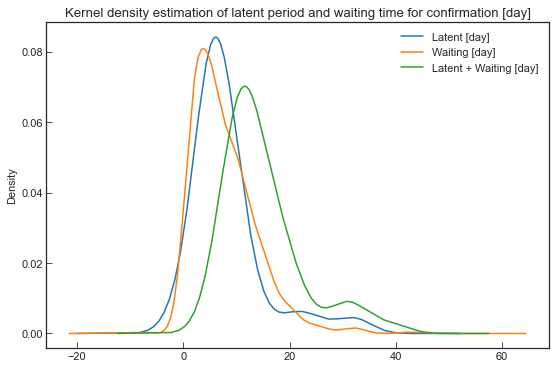

count       mean       std  min   25%   50%   75%  \
Latent [day]             83.0   8.180723  6.786185 -2.0   4.0   6.0   9.0   
Waiting [day]           563.0   7.682060  5.890473  0.0   3.0   6.0  11.0   
Latent + Waiting [day]   83.0  14.819277  7.305435  5.0  10.0  13.0  17.5   

                         max  
Latent [day]            34.0  
Waiting [day]           43.0  
Latent + Waiting [day]  40.0

In [83]:
cols = ["Latent [day]", "Waiting [day]", "Latent + Waiting [day]"]
period_df[cols].plot.kde()
plt.title("Kernel density estimation of latent period and waiting time for confirmation [day]")
plt.show()
period_df[cols].describe().T

In [84]:
action_raw = dd.read_csv(
    r"C:\Users\alshrooq\Desktop\NasaData\covid19-containment-and-mitigation-measures\COVID 19 Containment measures data.csv"
).compute()
#action_raw.head()

In [85]:
df  = action_raw.copy()
df = df.rename(
    {
        "Description of measure implemented": "Details",
        "Implementing State/Province": "Province",
    },
    axis=1
)
# Country/Province
df["Country"] = df["Country"].replace({"United Kingdom": "UK"})
df["Country"] = df["Country"].str.replace("US: ", "US/").str.replace("US:", "US/")
df = df.loc[~df["Country"].isnull(), :]
df["Province"] = df["Province"].fillna("-")
df[["Country", "Province", "-"]] = (df["Country"] + "/" + df["Province"]).str.split("/", expand=True)
# Date
df["Start_date"] = pd.to_datetime(df["Date Start"])
df["End_date"] = pd.to_datetime(df["Date end intended"])
df = df.loc[~df["Start_date"].isnull(), :]
# Detail
df = df.loc[~df["Details"].isnull(), :]
df["Keywords"] = df["Keywords"].fillna("-")
df["Exceptions"] = df["Exceptions"].fillna("-")
# _df = df["Keywords"].str.split(", ", expand=True)
# df = pd.concat([df, _df], axis=1)
# Save
df = df.loc[:, ["Country", "Province", "Start_date", "End_date", "Keywords", "Details", "Exceptions"]]
df = df.sort_values(["Start_date", "End_date", "Country", "Province"])
action_df = df.copy()
#action_df.head()

In [86]:
words = pd.Series(", ".join(action_df["Keywords"].tolist()).split(", ")).unique().tolist()
words

['first case',
 'compulsory isolation',
 'confirmed case isolation',
 'case reporting',
 'research',
 'source tracing',
 'international traveller quarantine - risk countries',
 'international traveller screening - all countries',
 'coronavirus education activities',
 'encouraging symptomatic people to seek tests',
 'international traveller screening - risk countries',
 'limited nonessential business suspension',
 'test travellers',
 'contacts traced total',
 'outbound travel warning',
 'public announcement',
 'special management arrangements',
 'task group',
 'hospital specialisation',
 'contact isolation - no symptoms',
 'contact tracing',
 'public mask and hygiene supply',
 'testing commenced',
 'international travel ban - risk countries',
 'international traveller screening - symptomatic',
 'general nonessential business suspension',
 'hygiene enforcement',
 'quarantine zone',
 'cluster isolation - no symptoms',
 'traveller testing',
 'wild animal ban',
 'phone line',
 'moves of med

In [87]:
vectorizer = TfidfVectorizer(use_idf=True)
vecs = vectorizer.fit_transform(words)
clusters = KMeans(n_clusters=20, random_state=0).fit_predict(vecs)
df = pd.DataFrame(
    {
        "Group": clusters,
        "Word": words
    }
)
df = df.sort_values("Group")
df = pd.DataFrame(df.groupby("Group")["Word"].apply(lambda x: ", ".join(x)))
df

Word
Group                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
0      sentence, epidemic data, ban on visit to nursing homes, intellectual property, unemployment benefits extension, medical staff protective equipment, handwashing encouragement, retired doctors called, restaurant limitations, eviction moratorium, activism for stricter measures, first death, military takeover, outdoor gatherings banned, manufacturing capacity, economic stimulus, emergency declaration, weddings canceled, riots, social distancing, prisons closed to visitors, business resumed, quaratine violation, price gouging ban, -, total vehicle ban, community spread, low compliance, prisoner release, sewing plain clothes masks, army deployed, indoor person density, financial incentive, visa suspension, cash cleaning, clinic specialisation, symptom hotline, protective equipment supplies, indoor gatherings banned, medical aid, mitigation focus, elderly, economic incentives, wild animal ban, looking for children, evictions prohibited, shopping vouchers, space minimum, exam postpone, hea...
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        airport closure, school closure - limited, public green closure, closure of gathering places, closure nonessential stores, school closure, university closure, nursery school closure
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                domestic traveller screening, international traveller quarantine - risk countries, international traveller screening - all countries, international traveller screening - risk countries, outbound traveller ban, international aid, international travel ban - all countries, international travel ban - risk countries, international traveller screening - symptomatic, international trav

# Measures in Italy

In [88]:
ita_action_raw = pd.read_excel(
    r"C:\Users\alshrooq\Desktop\NasaData\covid19-prevention-in-italy\Dataset_Italy_COVID_19.xlsx",
    sheet_name="Foglio1"
)
ita_action_raw.head()

Country            Region  \
0   Italy               NaN   
1   Italy               NaN   
2   Italy               NaN   
3   Italy               NaN   
4   Italy  Lombardia,Veneto   

                                                                                                                                                                      Village  \
0                                                                                                                                                                         NaN   
1                                                                                                                                                                         NaN   
2                                                                                                                                                                         NaN   
3                                                                                                                                                                         NaN   
4  Vo’ Euganeo (Veneto) e Codogno, Castiglione d’Adda, Casalpusterlengo, Fombio, Maleo, Somaglia, Bertonico, Terranova dei Passerini, Castelgerundo e San Fiorano (Lombardia)   

    Start date     End Date  \
0  30-jan-2020          NaN   
1  03-feb-2020          NaN   
2  06-feb-2020          NaN   
3  21-feb-2020  21-feb-2020   
4  23-feb-2020          NaN   

                                                  Action  \
0                                   Restriction of entry   
1                               Leave from epidemic area   
2                                 Control in the Airport   
3                                            Quaranteene   
4  containment and management the Italian infected areas   

                                                                                                                                                                                               Detail  \
0                                                                                                                                                   All flights to and from China have been suspended   
1                                                                         Return of people present in countries at risk and return of foreign citizens to the countries of origin exposed to the risk   
2                                                                                                                               Airport monitoring and control for domestic and international flights   
3  Mandatory quarantine isolation for close contacts with a positive cases, and provides active surveillance with fiduciary home permanence for those who have been in risk areas in the last 14 days   
4                                                                   decree-law introducing urgent measures regarding the containment and management of the epidemiological emergency from COVID-2019.   

  Number of people                                                        link  
0              NaN  http://www.governo.it/it/approfondimento/coronavirus/13968  
1              NaN  http://www.governo.it/it/approfondimento/coronavirus/13969  
2            62000  http://www.governo.it/it/approfondimento/coronavirus/13970  
3              NaN  http://www.governo.it/it/approfondimento/coronavirus/13971  
4           53856‬  http://www.governo.it/it/approfondimento/coronavirus/13972

In [89]:
df = ita_action_raw.copy()
df = df.drop(["Country", "Village", "link"], axis=1)
df.columns = [col.capitalize().replace(" ", "_") for col in df.columns]
df["Start_date"] = pd.to_datetime(df["Start_date"])
df["End_date"] = pd.to_datetime(df["End_date"])
df["Region"] = df["Region"].fillna("-")
df["Number_of_people"] = df["Number_of_people"].fillna(-1)
ita_action_df = df.copy()
ita_action_df.tail()

Region  \
7   Emilia Romagna,Friuli Venezia Giulia, Lombardia, Veneto, Piemonte e Liguria,   
8                                                                              -   
9                                                                              -   
10                                                                             -   
11                                                                             -   

   Start_date   End_date  \
7  2020-03-07 2020-03-07   
8  2020-03-09 2020-05-04   
9  2020-03-19        NaT   
10 2020-03-20        NaT   
11 2020-04-14        NaT   

                                                        Action  \
7   more containment and management the Italian infected areas   
8                                                     lockdown   
9                                      Medicine sperimentation   
10                                                  task force   
11                                        open some businesses   

                                                                                                                                        Detail  \
7                                     prohibit any movement in Lombardy and in fourteen provinces of Veneto, Emilia Romagna, Piedmont, Marche.   
8         people must stay at home and go out only for food or work needs. Many activities are closed and only the essential ones remain open.   
9   testing began on the drug Tocilizumab, a drug used against rheumatoid arthritis that has had beneficial effects against COVID-19 in China.   
10                 create a task force of doctors from all over Italy to be able to send to the territories with the greatest health problems.   
11                                                     Reopening of some production activities, newsagents, baby clothing stores, freelancers.   

   Number_of_people  
7                -1  
8          60483973  
9               330  
10               -1  
11               -1

# The number of cases in Japan

In [90]:
jpn_pref_raw = pd.read_csv(r"C:\Users\alshrooq\Desktop\NasaData\covid19-dataset-in-japan\covid_jpn_prefecture.csv")
jpn_pref_raw.tail()

Date Prefecture  Positive  Tested  Discharged  Fatal  \
3379  2020-05-28   Kumamoto        48  3885.0        39.0    3.0   
3380  2020-05-28       Oita        60  3927.0        58.0    1.0   
3381  2020-05-28   Miyazaki        17  1363.0        17.0    0.0   
3382  2020-05-28  Kagoshima        10  1852.0        10.0    0.0   
3383  2020-05-28    Okinawa       142  2843.0       136.0    6.0   

      Hosp_require  Hosp_severe  
3379           6.0          0.0  
3380           1.0          0.0  
3381           0.0          0.0  
3382           0.0          0.0  
3383           4.0          2.0

In [91]:
df = jpn_pref_raw.copy()
df.dropna(how="all", inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
sel = df.columns.isin(["Date", "Prefecture"])
df = df.groupby("Prefecture").apply(
    lambda x: x.set_index("Date").resample("D").interpolate("linear")
)
df = df.fillna(0)
df = df.drop("Prefecture", axis=1).reset_index()
df = df.sort_values("Date").reset_index(drop=True)
sel = df.columns.isin(["Date", "Prefecture"])
df.loc[:, ~sel] = df.loc[:, ~sel].interpolate("linear").astype(np.int64)
jpn_pref_df = df.copy()
jpn_pref_df.tail()

Prefecture       Date  Positive  Tested  Discharged  Fatal  Hosp_require  \
3379      Osaka 2020-05-28      1782   30162        1539     82           148   
3380    Ibaraki 2020-05-28       168    4601         149     10             9   
3381    Okinawa 2020-05-28       142    2843         136      6             4   
3382   Shizuoka 2020-05-28        76    3491          71      1             4   
3383  Yamanashi 2020-05-28        60    3842          57      1             2   

      Hosp_severe  
3379           19  
3380            0  
3381            2  
3382            1  
3383            0

In [92]:
jpn_meta_raw = pd.read_csv(r"C:\Users\alshrooq\Desktop\NasaData\covid19-dataset-in-japan\covid_jpn_metadata.csv")
jpn_meta_raw.tail()

Prefecture Category Item Value        Date  \
841   Kumamoto    Admin  Num    43  2012-04-27   
842       Oita    Admin  Num    44  2012-04-27   
843   Miyazaki    Admin  Num    45  2012-04-27   
844  Kagoshima    Admin  Num    46  2012-04-27   
845    Okinawa    Admin  Num    47  2012-04-27   

                                           Primary_source Secondary_source  
841  http://nlftp.mlit.go.jp/ksj/gml/codelist/PrefCd.html              NaN  
842  http://nlftp.mlit.go.jp/ksj/gml/codelist/PrefCd.html              NaN  
843  http://nlftp.mlit.go.jp/ksj/gml/codelist/PrefCd.html              NaN  
844  http://nlftp.mlit.go.jp/ksj/gml/codelist/PrefCd.html              NaN  
845  http://nlftp.mlit.go.jp/ksj/gml/codelist/PrefCd.html              NaN

In [93]:
df = jpn_meta_raw.copy()
df["Title"] = df["Category"].str.cat(df["Item"], sep="_")
df = df.pivot_table(
    index="Prefecture", columns="Title", values="Value", aggfunc="last"
)
# Integer
cols = df.columns.str.startswith("Population")
cols += df.columns.str.startswith("Area")
cols += df.columns.str.startswith("Hospital_bed")
cols += df.columns.str.startswith("Clinic_bed")
df.loc[:, cols] = df.loc[:, cols].astype(np.int64)
df["Admin_Num"] = df["Admin_Num"].astype(np.int64)
# Numeric
cols = df.columns.str.startswith("Location")
df.loc[:, cols] = df.loc[:, cols].astype(np.float64)
# Sorting
df = df.loc[jpn_meta_raw["Prefecture"].unique(), :]
jpn_meta_df = df.copy()
jpn_meta_df.head()

Title      Admin_Captial  Admin_Num Admin_Region Area_Habitable Area_Total  \
Prefecture                                                                   
Hokkaido         Sapporo          1     Hokkaido          22373      83424   
Aomori            Aomori          2       Tohoku           3230       9646   
Iwate            Morioka          3       Tohoku           3714      15275   
Miyagi            Sendai          4       Tohoku           3155       7282   
Akita              Akita          5       Tohoku           3204      11638   

Title      Clinic_bed_Care Clinic_bed_Total Hospital_bed_Care  \
Prefecture                                                      
Hokkaido               428             5585             20822   
Aomori                 114             1906              2614   
Iwate                   98             1255              2310   
Miyagi                  91             1468              3431   
Akita                   77              721              2035   

Title      Hospital_bed_Specific Hospital_bed_Total Hospital_bed_Tuberculosis  \
Prefecture                                                                      
Hokkaido                       0              93050                       153   
Aomori                         0              17075                        33   
Iwate                          0              16557                        91   
Miyagi                         0              25121                        28   
Akita                          0              14627                        44   

Title      Hospital_bed_Type-I Hospital_bed_Type-II  Location_Latitude  \
Prefecture                                                               
Hokkaido                     2                   92          43.065063   
Aomori                       1                   28          40.824592   
Iwate                        2                   36          39.703670   
Miyagi                       2                   27          38.268915   
Akita                        2                   30          39.718353   

Title       Location_Longitude Population_Female Population_Male  \
Prefecture                                                         
Hokkaido            141.347644              2814            2506   
Aomori              140.740031               678             600   
Iwate               141.152717               651             604   
Miyagi              140.872212              1188            1136   
Akita               140.103416               528             468   

Title      Population_Total  
Prefecture                   
Hokkaido               5320  
Aomori                 1278  
Iwate                  1255  
Miyagi                 2323  
Akita                   996

# Grouping by growth factor

# Calculate growth factor

In [94]:
df = ncov_df.pivot_table(
    index="Date", columns="Country", values="Confirmed", aggfunc="sum"
).fillna(method="ffill").fillna(0)
# Growth factor: (delta Number_n) / (delta Number_n)
df = df.diff() / df.diff().shift(freq="D")
df = df.replace(np.inf, np.nan).fillna(1.0)
# Rolling mean (window: 7 days)
df = df.rolling(7).mean().dropna().loc[:ncov_df["Date"].max(), :]
# round: 0.01
growth_value_df = df.round(2)
growth_value_df.tail()

Country      Azerbaijan  Afghanistan  Albania  Algeria  Andorra  Angola  \
Date                                                                      
2020-05-18          1.0         1.09     1.34     1.01     0.74    0.86   
2020-05-26          1.0         1.04     3.48     1.02     0.71    1.42   
2020-05-27          1.0         1.05     1.46     1.00     0.71    1.57   
2020-05-28          1.0         1.03     1.59     0.96     0.86    1.85   
2020-05-29          1.0         0.89     1.24     0.82     0.86    1.80   

Country     Antigua and Barbuda  Argentina  Armenia  Aruba  ...  Uzbekistan  \
Date                                                        ...               
2020-05-18                  1.0       1.05     1.30    1.0  ...        1.28   
2020-05-26                  1.0       1.06     1.07    1.0  ...        1.52   
2020-05-27                  1.0       1.07     1.10    1.0  ...        1.44   
2020-05-28                  1.0       1.03     1.07    1.0  ...        1.54   
2020-05-29                  1.0       0.87     0.93    1.0  ...        1.17   

Country     Vatican City  Venezuela  Vietnam  West Bank and Gaza  \
Date                                                               
2020-05-18           1.0       2.20     1.08                1.63   
2020-05-26           1.0       0.90     0.86                1.41   
2020-05-27           1.0       0.96     0.71                1.20   
2020-05-28           1.0       1.18     0.71                1.03   
2020-05-29           1.0       1.03     0.71                1.03   

Country     Western Sahara  Yemen  Zambia  Zimbabwe  \
Date                                                  
2020-05-18            1.00   1.18    6.67      0.71   
2020-05-26            0.86   1.18    1.52      0.79   
2020-05-27            0.86   1.18    0.88      0.79   
2020-05-28            0.86   1.52    0.80      0.60   
2020-05-29            0.86   1.39    0.71      0.60   

Country     occupied Palestinian territory  
Date                                        
2020-05-18                             1.0  
2020-05-26                             1.0  
2020-05-27                             1.0  
2020-05-28                             1.0  
2020-05-29                             1.0  

[5 rows x 219 columns]

# Grouping countires based on growth factor

Outbreaking: growth factor  >  1 for the last 7 days
Stopping: growth factor  <  1 for the last 7 days
At a crossroad: the others

In [95]:
df = growth_value_df.copy()
df = df.iloc[-7:, :].T
day_cols = df.columns.strftime("%d%b%Y")
df.columns = day_cols
last_date = day_cols[-1]
# Grouping
more_col, less_col = "GF > 1 [straight days]", "GF < 1 [straight days]"
df[more_col] = (growth_value_df > 1).iloc[::-1].cumprod().sum(axis=0)
df[less_col] = (growth_value_df < 1).iloc[::-1].cumprod().sum(axis=0)
df["Group"] = df[[more_col, less_col]].apply(
    lambda x: "Outbreaking" if x[0] >= 7 else "Stopping" if x[1] >= 7 else "Crossroad",
    axis=1
)
# Sorting
df = df.loc[:, ["Group", more_col, less_col, *day_cols]]
df = df.sort_values(["Group", more_col, less_col], ascending=False)
growth_df = df.copy()
growth_df.head()

Group  GF > 1 [straight days]  GF < 1 [straight days]  \
Country                                                               
Nicaragua  Stopping                       0                      39   
Zimbabwe   Stopping                       0                      37   
Botswana   Stopping                       0                      34   
Cameroon   Stopping                       0                      25   
Andorra    Stopping                       0                      23   

           27Apr2020  28Apr2020  18May2020  26May2020  27May2020  28May2020  \
Country                                                                       
Nicaragua       0.71       0.71       0.86       0.71       0.71       0.71   
Zimbabwe        0.86       0.71       0.71       0.79       0.79       0.60   
Botswana        0.86       0.86       0.71       0.61       0.61       0.61   
Cameroon        0.78       0.78       0.77       0.85       0.70       0.46   
Andorra         0.55       0.55       0.74       0.71       0.71       0.86   

           29May2020  
Country               
Nicaragua       0.86  
Zimbabwe        0.60  
Botswana        0.71  
Cameroon        0.57  
Andorra         0.86

In [96]:
df = pd.merge(ncov_df, growth_df["Group"].reset_index(), on="Country")
ncov_df = df.loc[:, ["Date", "Group", *ncov_df.columns[1:]]]
ncov_df.tail()
df = growth_df.loc[growth_df["Group"] == "Outbreaking", :]
", ".join(df.index.tolist()) + "."

'Bahrain, Estonia, Latvia, Kenya, Mali, Albania, South Africa, Rwanda, Luxembourg, Maldives, Malta, Costa Rica, Israel, Moldova, North Macedonia, Sri Lanka, Uruguay, Eswatini, Austria, Bosnia and Herzegovina, Ethiopia, Iraq, China, Madagascar, Uzbekistan.'

In [98]:
growth_df.loc[growth_df["Group"] == "Outbreaking", :]

Group  GF > 1 [straight days]  \
Country                                                       
Bahrain                 Outbreaking                      39   
Estonia                 Outbreaking                      39   
Latvia                  Outbreaking                      39   
Kenya                   Outbreaking                      33   
Mali                    Outbreaking                      27   
Albania                 Outbreaking                      26   
South Africa            Outbreaking                      22   
Rwanda                  Outbreaking                      20   
Luxembourg              Outbreaking                      19   
Maldives                Outbreaking                      16   
Malta                   Outbreaking                      14   
Costa Rica              Outbreaking                      13   
Israel                  Outbreaking                      12   
Moldova                 Outbreaking                      12   
North Macedonia         Outbreaking                      12   
Sri Lanka               Outbreaking                      12   
Uruguay                 Outbreaking                      11   
Eswatini                Outbreaking                      10   
Austria                 Outbreaking                       9   
Bosnia and Herzegovina  Outbreaking                       9   
Ethiopia                Outbreaking                       9   
Iraq                    Outbreaking                       9   
China                   Outbreaking                       7   
Madagascar              Outbreaking                       7   
Uzbekistan              Outbreaking                       7   

                        GF < 1 [straight days]  27Apr2020  28Apr2020  \
Country                                                                
Bahrain                                      0       1.55       1.35   
Estonia                                      0       1.57       1.69   
Latvia                                       0       1.19       1.51   
Kenya                                        0       1.15       1.15   
Mali                                         0       1.31       1.35   
Albania                                      0       1.03       1.07   
South Africa                                 0       1.15       1.11   
Rwanda                                       0       3.97       3.87   
Luxembourg                                   0       1.85       1.06   
Maldives                                     0       1.82       1.98   
Malta                                        0       1.08       1.23   
Costa Rica                                   0       1.88       1.95   
Israel                                       0       1.02       1.10   
Moldova                                      0       1.11       1.30   
North Macedonia                              0       1.40       1.60   
Sri Lanka                                    0       1.45       1.49   
Uruguay                                      0       1.48       1.53   
Eswatini                                     0       1.66       1.31   
Austria                                      0       1.07       1.07   
Bosnia and Herzegovina                       0       2.04       1.90   
Ethiopia                                     0       1.27       1.41   
Iraq                                         0       1.05       1.37   
China                                        0       1.18       1.32   
Madagascar                                   0       1.43       1.29   
Uzbekistan                                   0       1.45       1.48   

                        18May2020  26May2020  27May2020  28May2020  29May2020  
Country                                                                        
Bahrain                      1.02       1.59       1.69       1.73       1.61  
Estonia                      1.43       2.32       2.34       2.32       2.15  
Latvia                       2.35       1.63       1.58       1

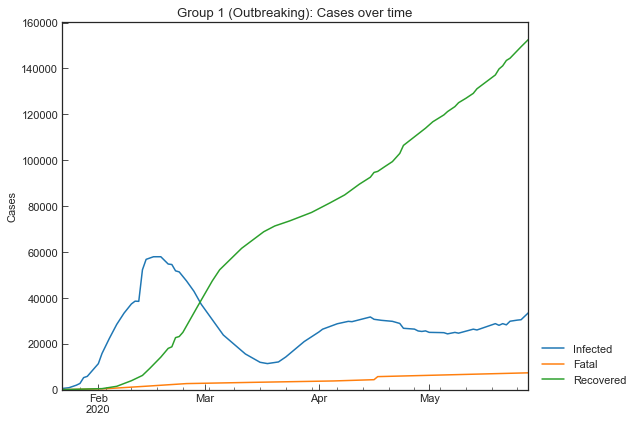

Infected  Fatal  Recovered
Date                                  
2020-05-24     30274   7080     146288
2020-05-25     30325   7156     147873
2020-05-26     30487   7226     149433
2020-05-27     32305   7281     150758
2020-05-28     33538   7355     152615

In [99]:
df = ncov_df.loc[ncov_df["Group"] == "Outbreaking", ["Date", *data_cols]].groupby("Date").sum()
cs.line_plot(df, "Group 1 (Outbreaking): Cases over time", y_integer=True)
df.tail()

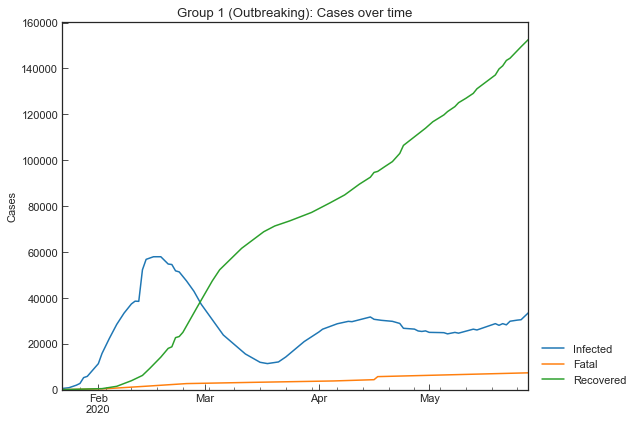

Infected  Fatal  Recovered
Date                                  
2020-05-24     30274   7080     146288
2020-05-25     30325   7156     147873
2020-05-26     30487   7226     149433
2020-05-27     32305   7281     150758
2020-05-28     33538   7355     152615

In [100]:
df = ncov_df.loc[ncov_df["Group"] == "Outbreaking", ["Date", *data_cols]].groupby("Date").sum()
cs.line_plot(df, "Group 1 (Outbreaking): Cases over time", y_integer=True)
df.tail()

In [101]:
growth_df.loc[growth_df["Group"] == "Stopping", :].head()

Group  GF > 1 [straight days]  GF < 1 [straight days]  \
Country                                                               
Nicaragua  Stopping                       0                      39   
Zimbabwe   Stopping                       0                      37   
Botswana   Stopping                       0                      34   
Cameroon   Stopping                       0                      25   
Andorra    Stopping                       0                      23   

           27Apr2020  28Apr2020  18May2020  26May2020  27May2020  28May2020  \
Country                                                                       
Nicaragua       0.71       0.71       0.86       0.71       0.71       0.71   
Zimbabwe        0.86       0.71       0.71       0.79       0.79       0.60   
Botswana        0.86       0.86       0.71       0.61       0.61       0.61   
Cameroon        0.78       0.78       0.77       0.85       0.70       0.46   
Andorra         0.55       0.55       0.74       0.71       0.71       0.86   

           29May2020  
Country               
Nicaragua       0.86  
Zimbabwe        0.60  
Botswana        0.71  
Cameroon        0.57  
Andorra         0.86

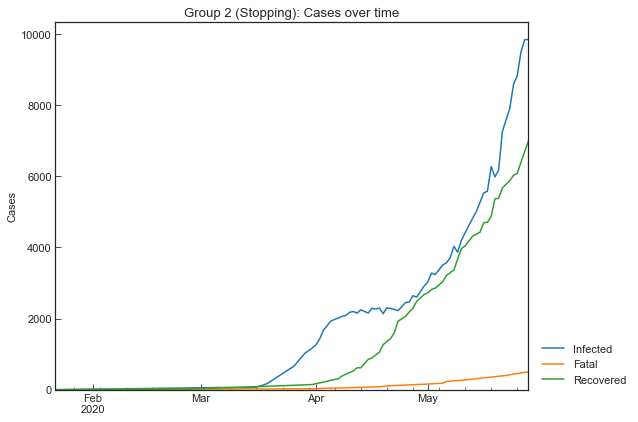

Infected  Fatal  Recovered
Date                                  
2020-05-24      8585    438       6027
2020-05-25      8831    443       6085
2020-05-26      9493    471       6438
2020-05-27      9840    498       6701
2020-05-28      9847    500       6987

In [102]:
df = ncov_df.loc[ncov_df["Group"] == "Stopping", ["Date", *data_cols]].groupby("Date").sum()
cs.line_plot(df, "Group 2 (Stopping): Cases over time", y_integer=True)
df.tail()

In [103]:
df = growth_df.loc[growth_df["Group"] == "Crossroad", :]
", ".join(df.index.tolist()) + "."

'Australia, Cuba, Lebanon, Finland, Ivory Coast, Japan, Kyrgyzstan, Mauritania, Nepal, Paraguay, Slovakia, Syria, Togo, West Bank and Gaza, Yemen, Angola, Central African Republic, France, Germany, Kosovo, Libya, Malawi, Morocco, Mozambique, Panama, Philippines, Sao Tome and Principe, Sierra Leone, South Korea, Georgia, Ghana, Senegal, Thailand, Jordan, Somalia, Venezuela, Barbados, Iceland, Spain, Bahamas, Canada, Gabon, Gambia, Guyana, Honduras, Lesotho, Slovenia, Tunisia, Burkina Faso, Cambodia, Comoros, Croatia, Djibouti, Ecuador, Kazakhstan, Kuwait, Mauritius, Monaco, Mongolia, Namibia, Saudi Arabia, Taiwan, Tajikistan, US, Uganda, Vietnam, Western Sahara, Burma, Cabo Verde, Guinea-Bissau, Hungary, Russia, Serbia, Zambia, Algeria, Belarus, Chad, Colombia, Haiti, Netherlands, Nigeria, Norway, Suriname, United Arab Emirates, Afghanistan, Argentina, Armenia, Azerbaijan, Bangladesh, Belgium, Bhutan, Bolivia, Brazil, Bulgaria, Chile, Congo, Cyprus, Czech Republic, Denmark, Dominican Re

In [104]:
growth_df.loc[growth_df["Group"] == "Crossroad", :].head()

Group  GF > 1 [straight days]  GF < 1 [straight days]  \
Country                                                                  
Australia    Crossroad                       6                       0   
Cuba         Crossroad                       6                       0   
Lebanon      Crossroad                       6                       0   
Finland      Crossroad                       5                       0   
Ivory Coast  Crossroad                       5                       0   

             27Apr2020  28Apr2020  18May2020  26May2020  27May2020  28May2020  \
Country                                                                         
Australia         0.82       1.15       1.18       1.42       1.22       1.19   
Cuba              0.89       1.10       1.27       1.37       1.16       1.19   
Lebanon           0.84       1.18       1.20       2.36       2.46       1.22   
Finland           1.10       0.91       1.22       1.24       1.22       1.17   
Ivory Coast       0.79       0.85       1.25       1.52       1.40       1.43   

             29May2020  
Country                 
Australia         1.15  
Cuba              1.04  
Lebanon           1.08  
Finland           1.05  
Ivory Coast       1.34

In [105]:
df = ncov_df.loc[ncov_df["Group"] == "Crossroad", ["Date", *data_cols]].groupby("Date").sum()
cs.line_plot(df, "Group 3 (At a crossroad): Cases over time", y_integer=True)
df.tail()

Infected   Fatal  Recovered
Date                                   
2020-05-25   2877935  338633    2077780
2020-05-26   2912237  342756    2131085
2020-05-27   2943928  347850    2192629
2020-05-28   2989341  352439    2256409
2020-05-29      1591     874      14254

# SIR model

In [106]:
eg_r0, eg_rho = (2.5, 0.2)
eg_sigma = eg_rho / eg_r0
eg_initials = (0.999, 0.001, 0)
display(Markdown(rf"$\rho = {eg_rho},\ \sigma = {eg_sigma}$."))

$\rho = 0.2,\ \sigma = 0.08$.

In [107]:
eg_population = 1_000_000
eg_tau = 1440
sir_param_dict = {
    "rho": eg_rho, "sigma": eg_sigma
}
sir_simulator = cs.ODESimulator(country="Example", province="SIR")
sir_simulator.add(
    model=cs.SIR, step_n=180, population=eg_population,
    param_dict=sir_param_dict,
    y0_dict={"x": 0.999, "y": 0.001, "z": 0}
)
sir_simulator.run()
sir_simulator.non_dim().tail()

t         x         y         z
176  176  0.106640  0.000658  0.892702
177  177  0.106626  0.000621  0.892753
178  178  0.106613  0.000585  0.892802
179  179  0.106601  0.000552  0.892847
180  180  0.106589  0.000521  0.892890

In [108]:
cs.line_plot(
    sir_simulator.non_dim().set_index("t"),
    title=r"SIR: $R_0={0}\ (\rho={1}, \sigma={2})$".format(eg_r0, eg_rho, eg_sigma),
    ylabel="",
    h=1
)

In [109]:
df = sir_simulator.non_dim()
x_max = df.loc[df["y"].idxmax(), "x"]
(x_max, 1/eg_r0)

(0.39661788452227087, 0.4)

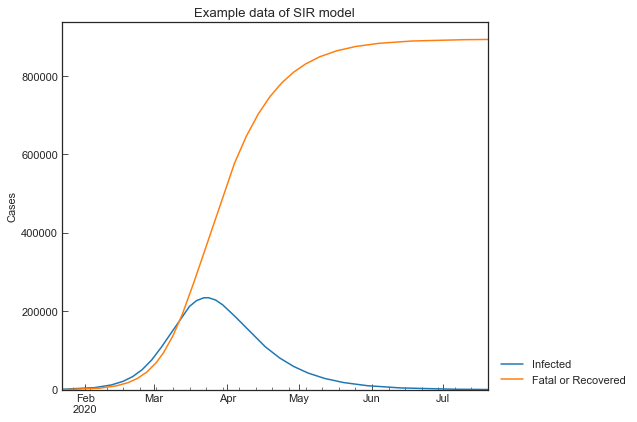

Date  Country Province  Confirmed  Fatal or Recovered  Infected
176 2020-07-16  Example      SIR     893360              892702       658
177 2020-07-17  Example      SIR     893374              892753       620
178 2020-07-18  Example      SIR     893386              892801       585
179 2020-07-19  Example      SIR     893399              892847       552
180 2020-07-20  Example      SIR     893410              892889       520

In [110]:
sir_eg_df = sir_simulator.dim(tau=eg_tau, start_date="22Jan2020")
cs.line_plot(
    sir_eg_df.set_index("Date")[["Infected", "Fatal or Recovered"]],
    "Example data of SIR model",
    h=eg_population, y_integer=True
)
sir_eg_df.tail()

In [111]:
eg_r0, eg_kappa, eg_rho = (2.5, 0.005, 0.2)
eg_sigma = eg_rho / eg_r0 - eg_kappa
eg_initials = (0.999, 0.001, 0, 0)
display(Markdown(rf"$\kappa = {eg_kappa},\ \rho = {eg_rho},\ \sigma = {eg_sigma}$."))

$\kappa = 0.005,\ \rho = 0.2,\ \sigma = 0.075$.

In [112]:
sird_param_dict = {
    "kappa": eg_kappa, "rho": eg_rho, "sigma": eg_sigma
}
sird_simulator = cs.ODESimulator(country="Example", province="SIR-D")
sird_simulator.add(
    model=cs.SIRD, step_n=180, population=eg_population,
    param_dict=sird_param_dict,
    y0_dict={"x": 0.999, "y": 0.001, "z": 0, "w": 0}
)
sird_simulator.run()
sird_simulator.non_dim().tail()

t         x         y         z         w
176  176  0.106749  0.000660  0.836803  0.055787
177  177  0.106736  0.000623  0.836851  0.055790
178  178  0.106723  0.000587  0.836897  0.055793
179  179  0.106711  0.000554  0.836939  0.055796
180  180  0.106699  0.000522  0.836980  0.055799

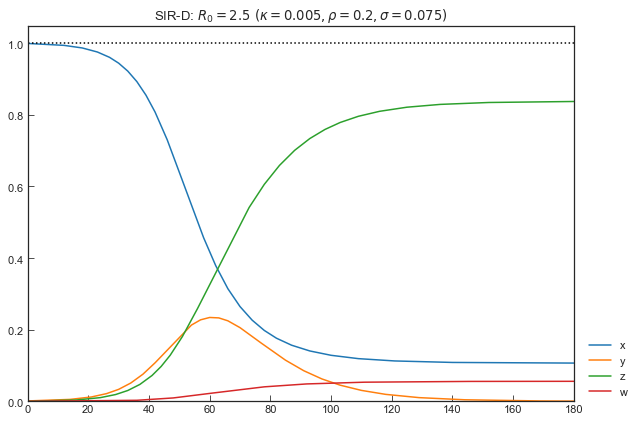

In [113]:
cs.line_plot(
    sird_simulator.non_dim().set_index("t"),
    title=r"SIR-D: $R_0={0}\ (\kappa={1}, \rho={2}, \sigma={3})$".format(eg_r0, eg_kappa, eg_rho, eg_sigma),
    ylabel="",
    h=1
)

In [114]:
df = sird_simulator.non_dim()
x_max = df.loc[df["y"].idxmax(), "x"]
(x_max, 1/eg_r0)

(0.39683686426375786, 0.4)

In [115]:
sird_eg_df = sird_simulator.dim(tau=eg_tau, start_date="22Jan2020")
cs.line_plot(
    sird_eg_df.set_index("Date")[["Infected", "Fatal", "Recovered"]],
    "Example data of SIR-D model",
    h=eg_population, y_integer=True
)
sird_eg_df.tail()

Date  Country Province  Confirmed  Fatal  Infected  Recovered
176 2020-07-16  Example    SIR-D     893250  55786       660     836803
177 2020-07-17  Example    SIR-D     893264  55790       622     836851
178 2020-07-18  Example    SIR-D     893277  55793       587     836896
179 2020-07-19  Example    SIR-D     893289  55795       553     836939
180 2020-07-20  Example    SIR-D     893300  55798       522     836979

In [116]:
eg_r0, eg_theta, eg_kappa, eg_rho = (2.5, 0.002, 0.005, 0.2)
eg_sigma = eg_rho / eg_r0 - eg_kappa
eg_initials = (0.999, 0.001, 0, 0)
display(Markdown(rf"$\theta = {eg_theta},\ \kappa = {eg_kappa},\ \rho = {eg_rho},\ \sigma = {eg_sigma}$."))

$\theta = 0.002,\ \kappa = 0.005,\ \rho = 0.2,\ \sigma = 0.075$.

In [117]:
sirf_param_dict = {
    "theta": eg_theta, "kappa": eg_kappa, "rho": eg_rho, "sigma": eg_sigma
}
sirf_simulator = cs.ODESimulator(country="Example", province="SIR-F")
sirf_simulator.add(
    model=cs.SIRF, step_n=180, population=eg_population,
    param_dict=sirf_param_dict,
    y0_dict={"x": 0.999, "y": 0.001, "z": 0, "w": 0}
)
sirf_simulator.run()
sirf_simulator.non_dim().tail()

t         x         y         z         w
176  176  0.107392  0.000670  0.834520  0.057418
177  177  0.107378  0.000632  0.834569  0.057421
178  178  0.107364  0.000596  0.834615  0.057424
179  179  0.107352  0.000562  0.834659  0.057427
180  180  0.107340  0.000530  0.834699  0.057430

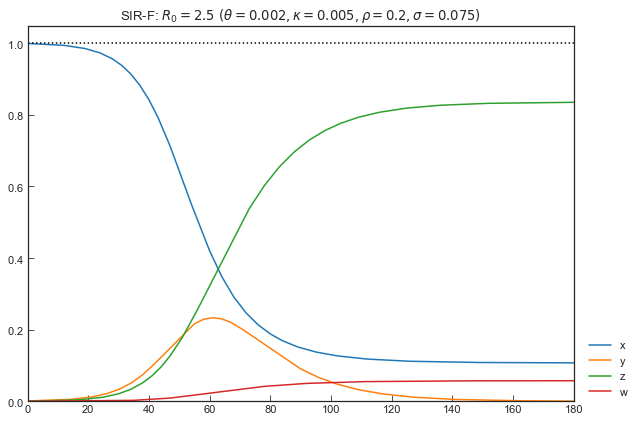

In [118]:
cs.line_plot(
    sirf_simulator.non_dim().set_index("t"),
    title=r"SIR-F: $R_0={0}\ (\theta={1}, \kappa={2}, \rho={3}, \sigma={4})$".format(
        eg_r0, eg_theta, eg_kappa, eg_rho, eg_sigma
    ),
    ylabel="",
    h=1
)

In [119]:
df = sirf_simulator.non_dim()
x_max = df.loc[df["y"].idxmax(), "x"]
(x_max, 1/eg_r0)

(0.40047837663671526, 0.4)

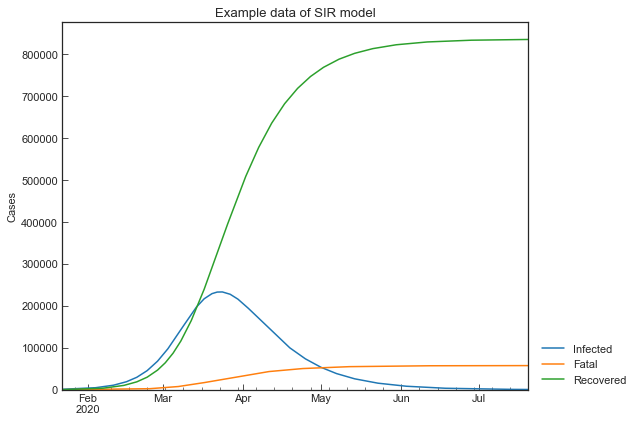

Date  Country Province  Confirmed  Fatal  Infected  Recovered
176 2020-07-16  Example    SIR-F     892608  57417       670     834520
177 2020-07-17  Example    SIR-F     892622  57421       632     834569
178 2020-07-18  Example    SIR-F     892635  57424       596     834615
179 2020-07-19  Example    SIR-F     892648  57427       562     834658
180 2020-07-20  Example    SIR-F     892659  57429       530     834699

In [120]:
sirf_eg_df = sirf_simulator.dim(tau=eg_tau, start_date="22Jan2020")
cs.line_plot(
    sirf_eg_df.set_index("Date")[["Infected", "Fatal", "Recovered"]],
    "Example data of SIR model",
    h=eg_population, y_integer=True
)
sirf_eg_df.tail()

In [121]:
estimator = cs.Estimator(
    clean_df=sirf_eg_df, model=cs.SIRF, population=eg_population,
    country="Example", province="SIR-F",
    tau=eg_tau
)
estimator.run()

	Running optimization...
	Finished 293 trials in 0 min 53 sec..


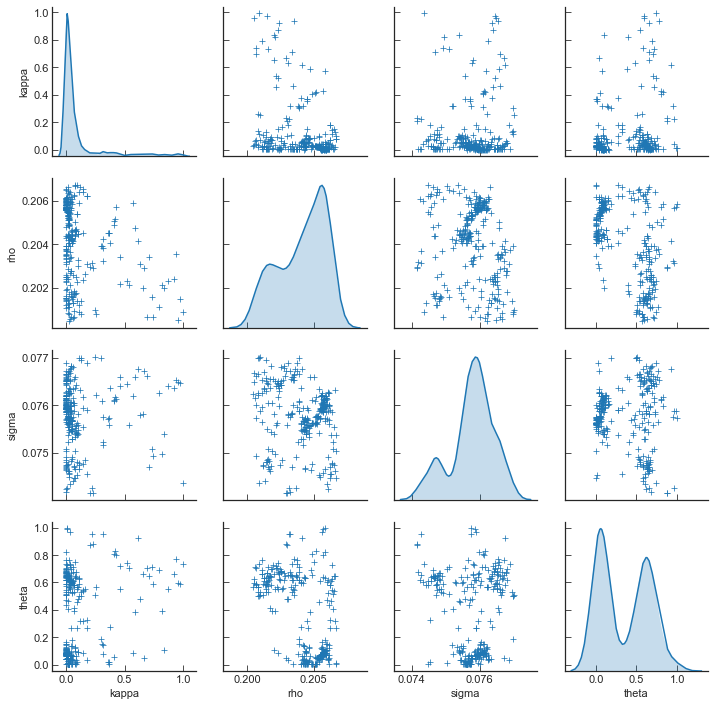

In [122]:
_ = estimator.history()

In [123]:
df = estimator.summary(name="SIR-F")
df.loc["Setted"] = pd.Series({**sirf_param_dict, "tau": eg_tau})
df.fillna("-")

theta     kappa       rho     sigma     tau    Rt alpha1 [-]  \
SIR-F   0.040497  0.001114  0.205645  0.076248  1440.0  2.55       0.04   
Setted  0.002000  0.005000  0.200000  0.075000  1440.0     -          -   

       1/alpha2 [day] 1/beta [day] 1/gamma [day]     RMSLE Trials  \
SIR-F             897            4            13  0.919363    293   
Setted              -            -             -         -      -   

             Runtime  
SIR-F   0 min 53 sec  
Setted             -

C:\Users\alshrooq\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\alshrooq\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\alshrooq\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\alshrooq\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDe

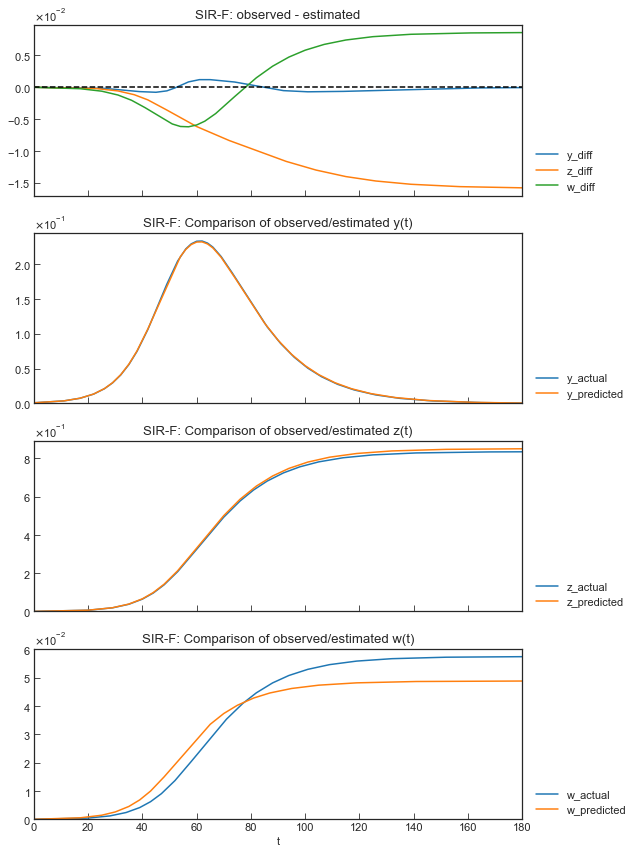

In [124]:
_ = estimator.accuracy()

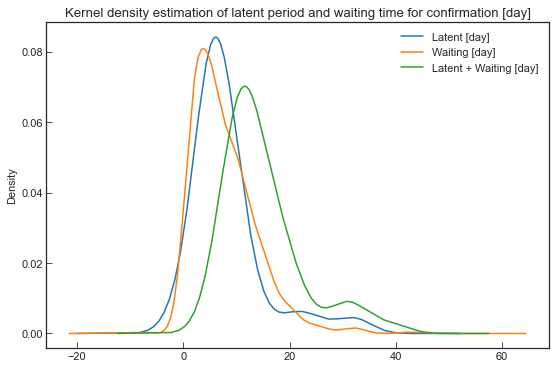

count       mean       std  min   25%   50%   75%  \
Latent [day]             83.0   8.180723  6.786185 -2.0   4.0   6.0   9.0   
Waiting [day]           563.0   7.682060  5.890473  0.0   3.0   6.0  11.0   
Latent + Waiting [day]   83.0  14.819277  7.305435  5.0  10.0  13.0  17.5   

                         max  
Latent [day]            34.0  
Waiting [day]           43.0  
Latent + Waiting [day]  40.0

In [125]:
cols = ["Latent [day]", "Waiting [day]", "Latent + Waiting [day]"]
period_df[cols].plot.kde()
plt.title("Kernel density estimation of latent period and waiting time for confirmation [day]")
plt.show()
period_df[cols].describe().T

In [126]:
latent_period = period_df["Latent [min]"].median()
waiting_time = period_df["Waiting [min]"].median()
latent_waiting_day = period_df["Latent + Waiting [day]"].median()

In [127]:
df = estimator.summary(name="SIRF")
tau = df.loc[df.index[0], "tau"]
eg_rho2, eg_rho3 = tau / latent_period, tau / waiting_time
(eg_rho2, eg_rho3)

(0.16666666666666663, 0.16666666666666663)

In [128]:
eg_theta, eg_kappa, eg_rho1, eg_sigma = (0.002, 0.005, 0.2, 0.08)

In [129]:
sewirf_param_dict = {
    "theta": eg_theta, "kappa": eg_kappa,
    "rho1": eg_rho1, "rho2": eg_rho2, "rho3": eg_rho3, "sigma": eg_sigma
}
sewirf_simulator = cs.ODESimulator(country="Example", province="SEWIR-F")
sewirf_simulator.add(
    model=cs.SEWIRF, step_n=180, population=eg_population,
    param_dict=sewirf_param_dict,
    y0_dict={"x1": 0.994, "x2": 0.003, "x3": 0.002, "y": 0.001, "z": 0, "w": 0}
)
sewirf_simulator.run()
sewirf_simulator.non_dim().tail()

t        x1        x2        x3         y         z         w
176  176  0.032199  0.000073  0.000121  0.001024  0.907905  0.058677
177  177  0.032192  0.000069  0.000113  0.000959  0.907985  0.058682
178  178  0.032185  0.000064  0.000106  0.000899  0.908059  0.058687
179  179  0.032179  0.000060  0.000099  0.000842  0.908128  0.058691
180  180  0.032173  0.000056  0.000093  0.000788  0.908194  0.058695

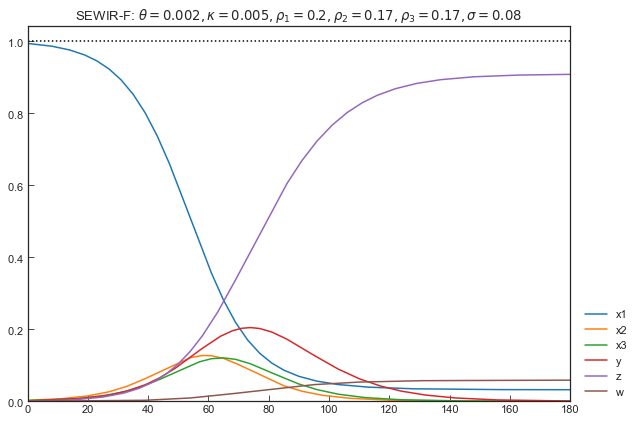

In [130]:
cs.line_plot(
    sewirf_simulator.non_dim().set_index("t"),
    title=r"SEWIR-F: $\theta={0}, \kappa={1}, \rho_1={2}, \rho_2={3}, \rho_3={4}, \sigma={5}$".format(
        eg_theta, eg_kappa, eg_rho1, round(eg_rho2, 2), round(eg_rho3, 2), eg_sigma
    ),
    ylabel="",
    h=1
)

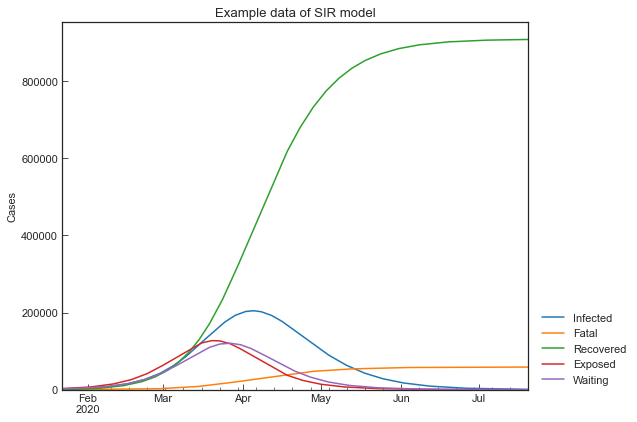

Date  Country Province  Confirmed  Exposed  Fatal  Infected  \
176 2020-07-16  Example  SEWIR-F     967606       73  58677      1024   
177 2020-07-17  Example  SEWIR-F     967626       68  58682       959   
178 2020-07-18  Example  SEWIR-F     967644       64  58686       898   
179 2020-07-19  Example  SEWIR-F     967661       60  58691       841   
180 2020-07-20  Example  SEWIR-F     967677       56  58695       788   

     Recovered  Waiting  
176     907905      120  
177     907984      113  
178     908058      106  
179     908128       99  
180     908193       92

In [131]:
sewirf_eg_df = sewirf_simulator.dim(tau=eg_tau, start_date="22Jan2020")
cs.line_plot(
    sewirf_eg_df.set_index("Date")[["Infected", "Fatal", "Recovered", "Exposed", "Waiting"]],
    "Example data of SIR model",
    h=eg_population, y_integer=True
)
sewirf_eg_df.tail()

In [132]:
# Value of beta before actions are taken
beta_before = eg_rho / eg_tau
beta_before

0.0001388888888888889

In [133]:
eg_out_df = go_out("Global")
eg_out_df

Age_first  Age_last     Period_of_life  School  Office  Others   Portion
0           0         2            nursery       3       0       0  0.052210
1           3         5     nursery school       4       0       1  0.051864
2           6        10  elementary school       5       0       1  0.084689
3          11        13      middle school       5       0       1  0.049386
4          14        18        high school       6       0       1  0.079324
5          19        25    university/work       3       3       1  0.107659
6          26        35               work       0       6       1  0.152774
7          36        45               work       0       5       1  0.131630
8          46        55               work       0       5       1  0.116396
9          56        65               work       0       5       1  0.088096
10         66        75            retired       0       0       4  0.055083
11         76        85            retired       0       0       3  0.024309
12         86        95            retired       0       0       2  0.006579

In [134]:
gs_before = (eg_out_df[["School", "Office", "Others"]].sum(axis=1) * eg_out_df["Portion"]).sum()
gs_before

5.921853248424339

In [135]:
df = eg_out_df.copy()
df.loc[df["School"] + df["Office"] > 0, "Others"] += 1
df["School"] = 0
df["Office"] *= 0.5
eg_out_df_after = df.copy()
eg_out_df_after

Age_first  Age_last     Period_of_life  School  Office  Others   Portion
0           0         2            nursery       0     0.0       1  0.052210
1           3         5     nursery school       0     0.0       2  0.051864
2           6        10  elementary school       0     0.0       2  0.084689
3          11        13      middle school       0     0.0       2  0.049386
4          14        18        high school       0     0.0       2  0.079324
5          19        25    university/work       0     1.5       2  0.107659
6          26        35               work       0     3.0       2  0.152774
7          36        45               work       0     2.5       2  0.131630
8          46        55               work       0     2.5       2  0.116396
9          56        65               work       0     2.5       2  0.088096
10         66        75            retired       0     0.0       4  0.055083
11         76        85            retired       0     0.0       3  0.024309
12         86        95            retired       0     0.0       2  0.006579

In [136]:
df = eg_out_df_after.copy()
gs_after = (df[["School", "Office", "Others"]].sum(axis=1) * df["Portion"]).sum()
gs_after

3.5423821085758442

In [137]:
beta_after = beta_before * (gs_after / gs_before)
beta_after / beta_before

0.5981880941609597

In [138]:
latent_waiting_day

13.0

In [139]:
param_dict = sirf_param_dict.copy()
lock_param_dict = param_dict.copy()
lock_param_dict["rho"] = param_dict["rho"] * beta_after / beta_before
df = pd.DataFrame.from_dict(
    {"No actions": param_dict, "Lockdown": lock_param_dict},
    orient="index"
)
df = df.loc[:, ["theta", "kappa", "rho", "sigma"]]
df["R0"] = df.apply(lambda x: cs.SIRF(**x.to_dict()).calc_r0(), axis=1)
df["tau"] = eg_tau
df

theta  kappa       rho  sigma    R0   tau
Lockdown    0.002  0.005  0.119638  0.075  1.49  1440
No actions  0.002  0.005  0.200000  0.075  2.50  1440

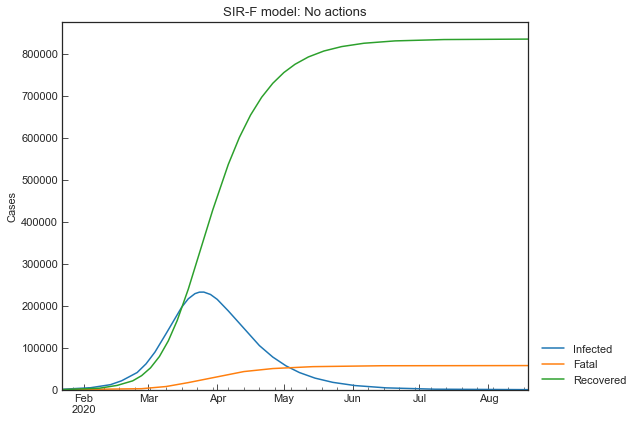

In [140]:
simulator = cs.ODESimulator(country="Example", province="No actions")
simulator.add(
    model=cs.SIRF,
    step_n=15,
    population=eg_population,
    param_dict=param_dict,
    y0_dict={"x": 0.999, "y": 0.001, "z": 0, "w": 0}
)
simulator.add(
    model=cs.SIRF,
    step_n=int(latent_waiting_day),
    population=eg_population,
    param_dict=param_dict
)
simulator.add(
    model=cs.SIRF,
    step_n=180,
    population=eg_population,
    param_dict=param_dict
)
simulator.run()
pred_df_no = simulator.dim(tau=eg_tau, start_date="22Jan2020").set_index("Date")
cs.line_plot(
    pred_df_no[["Infected", "Fatal", "Recovered"]],
    "SIR-F model: No actions", h=eg_population, y_integer=True
)

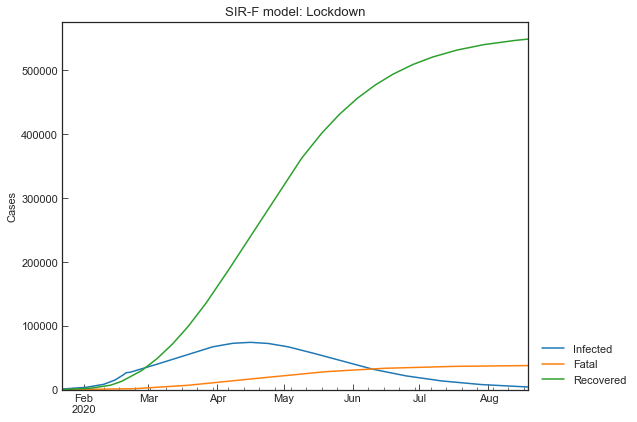

In [141]:
simulator = cs.ODESimulator(country="Example", province="Lockdown")
simulator.add(
    model=cs.SIRF,
    step_n=15,
    population=eg_population,
    param_dict=param_dict,
    y0_dict={"x": 0.999, "y": 0.001, "z": 0, "w": 0}
)
simulator.add(
    model=cs.SIRF,
    step_n=int(latent_waiting_day),
    population=eg_population,
    param_dict=param_dict
)
simulator.add(
    model=cs.SIRF,
    step_n=180,
    population=eg_population,
    param_dict=lock_param_dict
)
simulator.run()
pred_df_lock = simulator.dim(tau=eg_tau, start_date="22Jan2020").set_index("Date")
cs.line_plot(
    pred_df_lock[["Infected", "Fatal", "Recovered"]],
    "SIR-F model: Lockdown", h=eg_population, y_integer=True
)

In [142]:
_last_date = pred_df_no.index[-1].strftime("%d%b%Y")
_dict = {
    "No actions": {
        "max(Infected)": pred_df_no["Infected"].max(),
        "argmax(Infected)": pred_df_no["Infected"].idxmax(),
        f"Infected at {_last_date}": pred_df_no["Infected"][-1],
    },
    "With lockdown": {
        "max(Infected)": pred_df_lock["Infected"].max(),
        "argmax(Infected)": pred_df_lock["Infected"].idxmax(),
        f"Infected at {_last_date}": pred_df_lock["Infected"][-1],
    }   
}
pd.DataFrame.from_dict(_dict, orient="index")

max(Infected) argmax(Infected)  Infected at 19Aug2020
No actions            232825       2020-03-25                    104
With lockdown          74118       2020-04-16                   4189

In [143]:
gamma_before = param_dict["sigma"] / eg_tau
alpha2_before = param_dict["kappa"] / eg_tau
(gamma_before, alpha2_before)

(5.208333333333333e-05, 3.4722222222222224e-06)

In [144]:
h_bar_before, s_bar_before = 0.5, 0.5

In [145]:
h_bar_after = h_bar_before * 0.1
s_bar_after = s_bar_before
(h_bar_after, s_bar_after)

(0.05, 0.5)

In [146]:
gamma_after = gamma_before * (1 - h_bar_after * s_bar_after) / (1 - h_bar_before * s_bar_before)
gamma_after

6.770833333333333e-05

In [147]:
alpha2_after = alpha2_before * (h_bar_after * s_bar_after) / (h_bar_before * s_bar_before)
alpha2_after

3.4722222222222224e-07

In [148]:
param_dict = sirf_param_dict.copy()
med_param_dict = param_dict.copy()
med_param_dict["sigma"] = param_dict["sigma"] * gamma_after / gamma_before
med_param_dict["kappa"] = param_dict["kappa"] * alpha2_after / alpha2_before
df = pd.DataFrame.from_dict(
    {"No actions": param_dict, "Medicine": med_param_dict},
    orient="index"
)
df = df.loc[:, ["theta", "kappa", "rho", "sigma"]]
df["R0"] = df.apply(lambda x: cs.SIRF(**x.to_dict()).calc_r0(), axis=1)
df["tau"] = eg_tau
df

theta   kappa  rho   sigma    R0   tau
Medicine    0.002  0.0005  0.2  0.0975  2.04  1440
No actions  0.002  0.0050  0.2  0.0750  2.50  1440

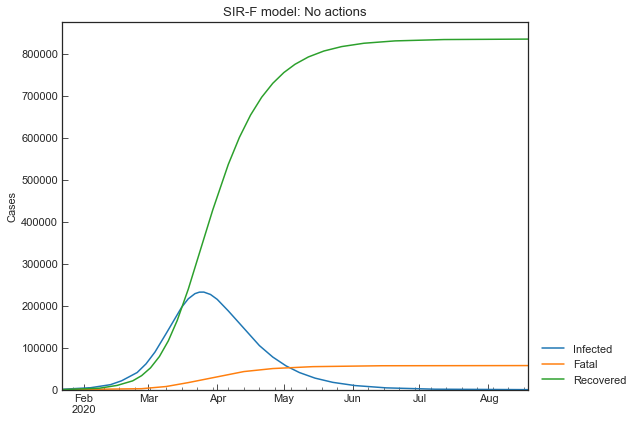

In [149]:
simulator = cs.ODESimulator(country="Example", province="No actions")
simulator.add(
    model=cs.SIRF,
    step_n=15,
    population=eg_population,
    param_dict=param_dict,
    y0_dict={"x": 0.999, "y": 0.001, "z": 0, "w": 0}
)
simulator.add(
    model=cs.SIRF,
    step_n=int(latent_waiting_day),
    population=eg_population,
    param_dict=param_dict
)
simulator.add(
    model=cs.SIRF,
    step_n=180,
    population=eg_population,
    param_dict=param_dict
)
simulator.run()
pred_df_no = simulator.dim(tau=eg_tau, start_date="22Jan2020").set_index("Date")
cs.line_plot(
    pred_df_no[["Infected", "Fatal", "Recovered"]],
    "SIR-F model: No actions", h=eg_population, y_integer=True
)

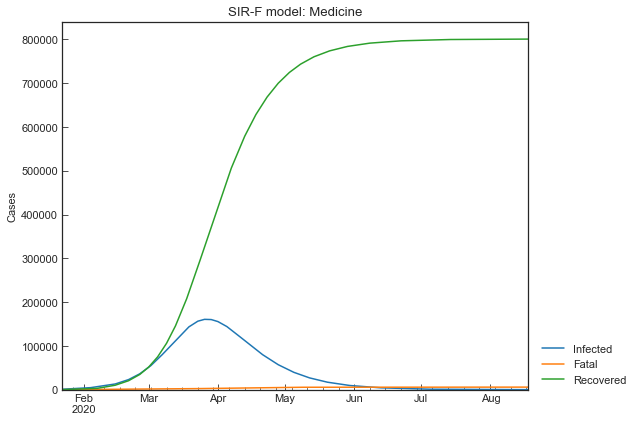

In [150]:
simulator = cs.ODESimulator(country="Example", province="Medicine")
simulator.add(
    model=cs.SIRF,
    step_n=15,
    population=eg_population,
    param_dict=param_dict,
    y0_dict={"x": 0.999, "y": 0.001, "z": 0, "w": 0}
)
simulator.add(
    model=cs.SIRF,
    step_n=int(latent_waiting_day) + 180,
    population=eg_population,
    param_dict=med_param_dict
)
simulator.run()
pred_df_med = simulator.dim(tau=eg_tau, start_date="22Jan2020").set_index("Date")
cs.line_plot(
    pred_df_med[["Infected", "Fatal", "Recovered"]],
    "SIR-F model: Medicine", h=eg_population, y_integer=True
)

In [151]:
_last_date = pred_df_no.index[-1].strftime("%d%b%Y")
_dict = {
    "No actions": {
        "max(Infected)": pred_df_no["Infected"].max(),
        "argmax(Infected)": pred_df_no["Infected"].idxmax(),
        f"Infected at {_last_date}": pred_df_no["Infected"][-1],
        f"Fatal at {_last_date}": pred_df_no["Fatal"][-1],
    },
    "Lockdown": {
        "max(Infected)": pred_df_lock["Infected"].max(),
        "argmax(Infected)": pred_df_lock["Infected"].idxmax(),
        f"Infected at {_last_date}": pred_df_lock["Infected"][-1],
        f"Fatal at {_last_date}": pred_df_lock["Fatal"][-1],
    },
    "Medicine": {
        "max(Infected)": pred_df_med["Infected"].max(),
        "argmax(Infected)": pred_df_med["Infected"].idxmax(),
        f"Infected at {_last_date}": pred_df_med["Infected"][-1],
        f"Fatal at {_last_date}": pred_df_med["Fatal"][-1],
    }
}
pd.DataFrame.from_dict(_dict, orient="index")


max(Infected) argmax(Infected)  Infected at 19Aug2020  \
Lockdown            74118       2020-04-16                   4189   
Medicine           161023       2020-03-27                     85   
No actions         232825       2020-03-25                    104   

            Fatal at 19Aug2020  
Lockdown                 37753  
Medicine                  5910  
No actions               57450

In [152]:
print(f"Total population is {eg_population:,}.")


Total population is 1,000,000.


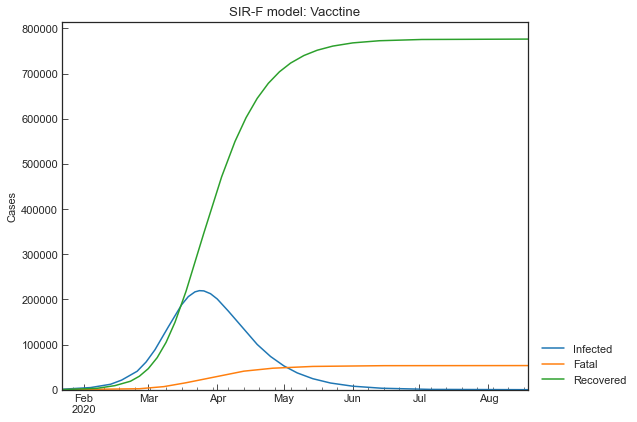

In [153]:
vac_param_dict = param_dict.copy()
vac_param_dict["omega"] = 1_000 / eg_population

simulator = cs.ODESimulator(country="Example", province="Vacctine")
simulator.add(
    model=cs.SIRF,
    step_n=15,
    population=eg_population,
    param_dict=param_dict,
    y0_dict={"x": 0.999, "y": 0.001, "z": 0, "w": 0}
)
simulator.add(
    model=cs.SIRF,
    step_n=int(latent_waiting_day),
    population=eg_population,
    param_dict=param_dict
)
simulator.add(
    model=cs.SIRFV,
    step_n=180,
    population=eg_population,
    param_dict=vac_param_dict
)
simulator.run()
pred_df_vac = simulator.dim(tau=eg_tau, start_date="22Jan2020").set_index("Date")
cs.line_plot(
    pred_df_vac[["Infected", "Fatal", "Recovered"]],
    "SIR-F model: Vacctine", h=eg_population, y_integer=True
)

In [154]:
_last_date = pred_df_no.index[-1].strftime("%d%b%Y")
_dict = {
    "No actions": {
        "max(Infected)": pred_df_no["Infected"].max(),
        "argmax(Infected)": pred_df_no["Infected"].idxmax(),
        f"Infected at {_last_date}": pred_df_no["Infected"][-1],
        f"Fatal at {_last_date}": pred_df_no["Fatal"][-1],
    },
    "Lockdown": {
        "max(Infected)": pred_df_lock["Infected"].max(),
        "argmax(Infected)": pred_df_lock["Infected"].idxmax(),
        f"Infected at {_last_date}": pred_df_lock["Infected"][-1],
        f"Fatal at {_last_date}": pred_df_lock["Fatal"][-1],
    },
    "Medicine": {
        "max(Infected)": pred_df_med["Infected"].max(),
        "argmax(Infected)": pred_df_med["Infected"].idxmax(),
        f"Infected at {_last_date}": pred_df_med["Infected"][-1],
        f"Fatal at {_last_date}": pred_df_med["Fatal"][-1],
    },
    "Vacctine": {
        "max(Infected)": pred_df_vac["Infected"].max(),
        "argmax(Infected)": pred_df_vac["Infected"].idxmax(),
        f"Infected at {_last_date}": pred_df_vac["Infected"][-1],
        f"Fatal at {_last_date}": pred_df_vac["Fatal"][-1],
    }
}
pd.DataFrame.from_dict(_dict, orient="index")

max(Infected) argmax(Infected)  Infected at 19Aug2020  \
Lockdown            74118       2020-04-16                   4189   
Medicine           161023       2020-03-27                     85   
No actions         232825       2020-03-25                    104   
Vacctine           219386       2020-03-25                     22   

            Fatal at 19Aug2020  
Lockdown                 37753  
Medicine                  5910  
No actions               57450  
Vacctine                 53402

In [155]:
df = pd.DataFrame()
eg_step_n = 200
eg_param_dict = {
    "1": {"theta": 0.0002, "kappa": 0.005, "rho": 0.20, "sigma": 0.075},
    "2": {"theta": 0.0002, "kappa": 0.005, "rho": 0.40, "sigma": 0.075},
    "3": {"theta": 0.0002, "kappa": 0.005, "rho": 0.15, "sigma": 0.075},
    "4": {"theta": 0.0002, "kappa": 0.003, "rho": 0.20, "sigma": 0.150},
    "5": {"theta": 0.0000, "kappa": 0.005, "rho": 0.20, "sigma": 0.075},
}

for (num, _dict) in eg_param_dict.items():
    simulator = cs.ODESimulator(country=f"Example {num}")
    simulator.add(
        model=cs.SIRF,
        step_n=eg_step_n,
        population=eg_population,
        param_dict=_dict,
        y0_dict={"x": 0.999, "y": 0.001, "z": 0, "w": 0}
    )
    simulator.run()
    _df = simulator.dim(tau=eg_tau, start_date="22Jan2020")
    df = pd.concat([df, _df], axis=0, ignore_index=True)

eg_ncov_df = df.copy()
eg_ncov_df.tail()

Date    Country Province  Confirmed  Fatal  Infected  Recovered
1000 2020-08-05  Example 5        -     893416  55825       204     837385
1001 2020-08-06  Example 5        -     893420  55826       193     837400
1002 2020-08-07  Example 5        -     893424  55827       182     837414
1003 2020-08-08  Example 5        -     893428  55828       171     837428
1004 2020-08-09  Example 5        -     893431  55829       161     837440

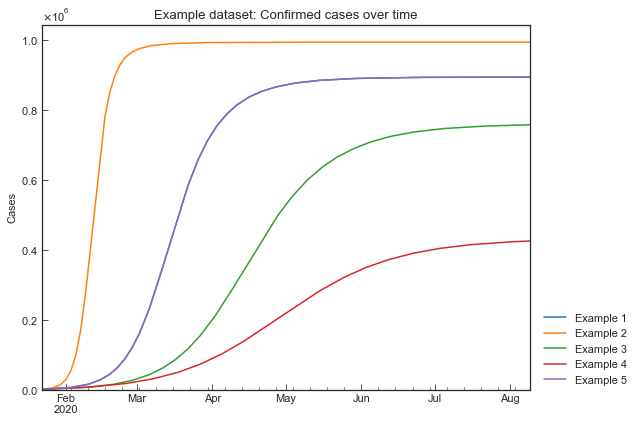

In [156]:
cs.line_plot(
    eg_ncov_df.pivot_table(index="Date", columns="Country", values="Confirmed"),
    "Example dataset: Confirmed cases over time"
)

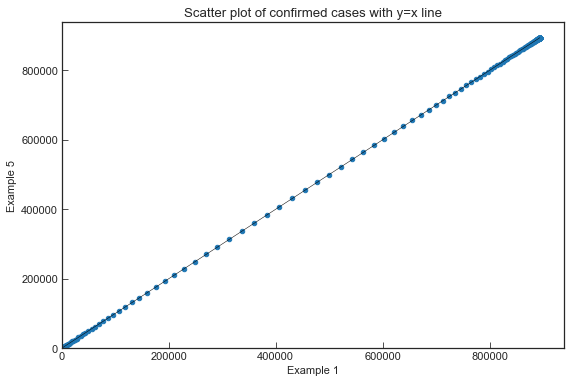

In [157]:
df = eg_ncov_df.pivot_table(index="Date", columns="Country", values="Confirmed")
df.plot.scatter(x="Example 1", y="Example 5")
plt.plot(df["Example 1"], df["Example 1"], color="black", linewidth=0.5)
plt.xlim(0, None)
plt.ylim(0, None)
plt.title("Scatter plot of confirmed cases with y=x line")
plt.show()

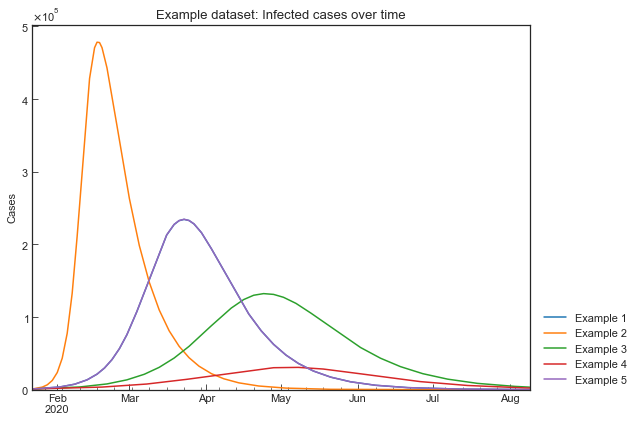

In [158]:
cs.line_plot(
    eg_ncov_df.pivot_table(index="Date", columns="Country", values="Infected"),
    "Example dataset: Infected cases over time"
)

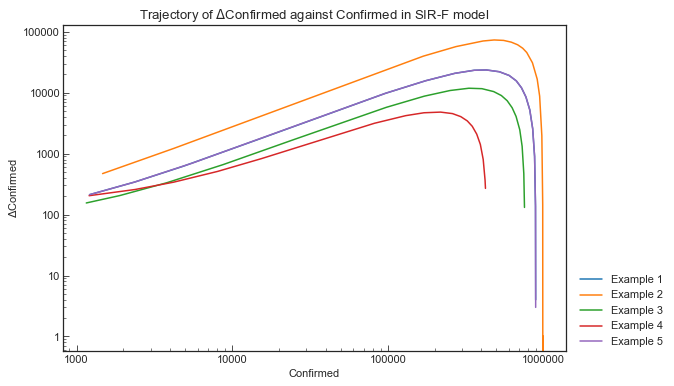

In [159]:
for country in eg_ncov_df["Country"].unique():
    df = eg_ncov_df.copy()
    df = df.loc[df["Country"] == country, :]
    df = df.groupby("Date").last()
    plt.plot(df["Confirmed"], df["Confirmed"].diff(), label=country)

plt.title(r"Trajectory of $\Delta$Confirmed against Confirmed in SIR-F model")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Confirmed")
plt.ylabel(r"$\Delta$Confirmed")
fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
fmt.set_scientific(False)
plt.gca().xaxis.set_major_formatter(fmt)
plt.gca().yaxis.set_major_formatter(fmt)
plt.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
plt.show()

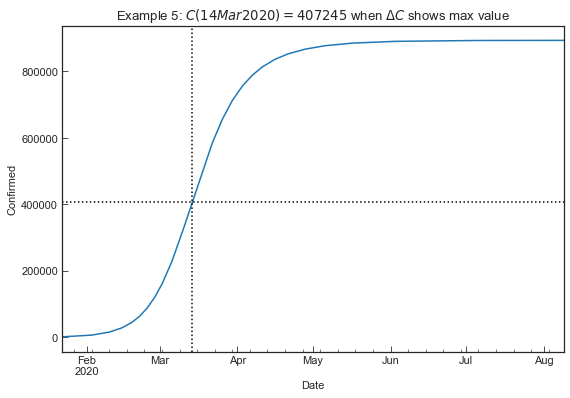

In [160]:
country = "Example 5"
df = eg_ncov_df.copy()
df = df.loc[df["Country"] == country, :].groupby("Date").last()
arg_tt = df["Confirmed"].diff().idxmax()
arg_cc = df.loc[arg_tt, "Confirmed"]
# Plot
df["Confirmed"].plot()
plt.axhline(y=arg_cc, color="black", linestyle=":")
plt.axvline(x=arg_tt, color="black", linestyle=":")
plt.ylabel("Confirmed")
plt.title(
    r'{0}: $C({1})={2}$ when $\Delta C$ shows max value'.format(
        country, arg_tt.strftime("%d%b%Y"), arg_cc)
)
fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
fmt.set_scientific(False)
plt.gca().yaxis.set_major_formatter(fmt)
plt.show()

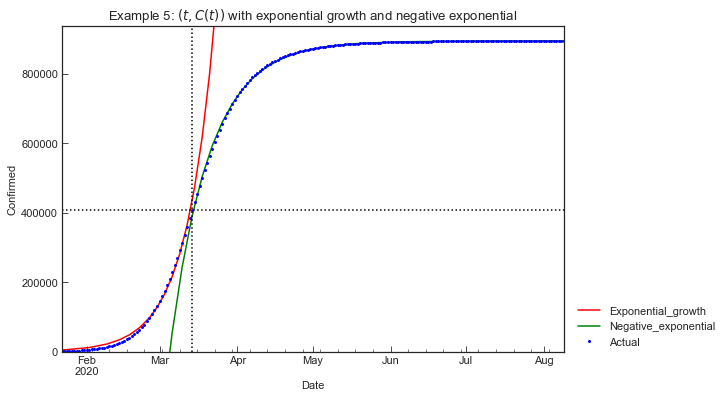

In [161]:
country = "Example 5"
df = eg_ncov_df.copy()
df = df.loc[df["Country"] == country, :].groupby("Date").last()
start_date = df.index.min()
arg_tt = df["Confirmed"].diff().idxmax()
arg_dd = int((arg_tt - start_date).total_seconds() / 60 / 60 / 24)
arg_cc = df.loc[arg_tt, "Confirmed"]
# Convert date to elapsed time (day)
df.index = ((df.index - start_date).total_seconds() / 60 / 60 / 24).astype(np.int64)
# Curve fitting with exponential growth function
f = lambda x, a, b: a * np.exp(b * x)
series = df.loc[df.index <= arg_dd, "Confirmed"]
a_ini = series[0]
b_ini = np.log(arg_cc / a_ini) / arg_dd
param, _ = sci.optimize.curve_fit(f, series.index, series, p0=[a_ini, b_ini])
f_partial = functools.partial(f, a=param[0], b=param[1])
df["Exponential_growth"] = pd.Series(df.index).apply(lambda x: f_partial(x))
# Curve fitting with negative exponential function
f = lambda x, a, b, c: c - a * np.exp(- b * (x - arg_dd))
series = df.loc[df.index >= arg_dd, "Confirmed"]
c_ini = series.max()
a_ini = c_ini - arg_cc
b_ini = series.diff()[arg_dd + 1] / a_ini
param, _ = sci.optimize.curve_fit(f, series.index, series, p0=[a_ini, b_ini, c_ini])
f_partial = functools.partial(f, a=param[0], b=param[1], c=param[2])
df["Negative_exponential"] = pd.Series(df.index).apply(lambda x: f_partial(x))
# Convert elapsed time (day) to date
df.index = start_date + pd.Series(df.index).apply(lambda x: timedelta(days=x))
# Plot
df[["Exponential_growth", "Negative_exponential"]].plot(color=["red", "green"])
df["Actual"] = df["Confirmed"]
df["Actual"].plot(color="blue", marker=".", markeredgewidth=0, linewidth=0)
plt.axhline(y=arg_cc, color="black", linestyle=":")
plt.axvline(x=arg_tt, color="black", linestyle=":")
plt.ylabel("Confirmed")
plt.ylim(0, max(df["Confirmed"]) * 1.05)
plt.title(r"{0}: $(t, C(t))$ with exponential growth and negative exponential".format(country))
fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
fmt.set_scientific(False)
plt.gca().yaxis.set_major_formatter(fmt)
plt.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
plt.show()

In [162]:
S = sym.symbols("S", cls=sym.Function)
N, R = sym.symbols("N R", positive=True)
beta, gamma = sym.symbols(r"\beta \gamma", positive=True)
dSdR = - beta / (N * gamma) * S(R)
sr = sym.dsolve(S(R).diff(R) - dSdR, hint="separable", ics={S(0): N})
sr

Eq(S(R), N*exp(-R*\beta/(N*\gamma)))

In [163]:
sym.Eq(sym.simplify(sym.log(sr.lhs)), sym.simplify(sym.log(sr.rhs)))


Eq(log(S(R)), log(N) - R*\beta/(N*\gamma))

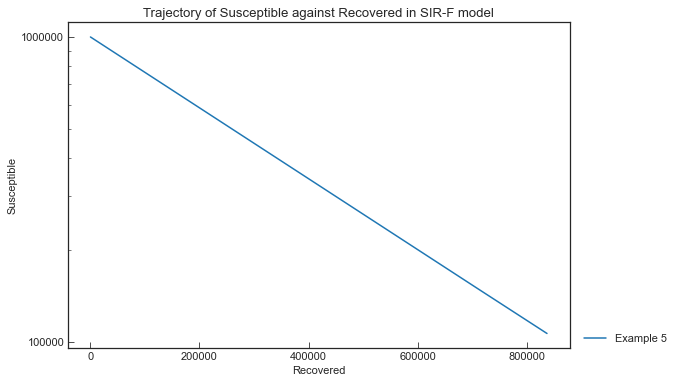

In [164]:
    df = eg_ncov_df.copy()
    df = df.loc[df["Country"] == country, :]
    df = df.groupby("Date").last()
    plt.plot(df["Recovered"], eg_population - df["Confirmed"], label=country)

plt.title(r"Trajectory of Susceptible against Recovered in SIR-F model")
plt.yscale("log")
plt.xlabel("Recovered")
plt.ylabel("Susceptible")
fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
fmt.set_scientific(False)
plt.gca().xaxis.set_major_formatter(fmt)
plt.gca().yaxis.set_major_formatter(fmt)
plt.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
plt.show()

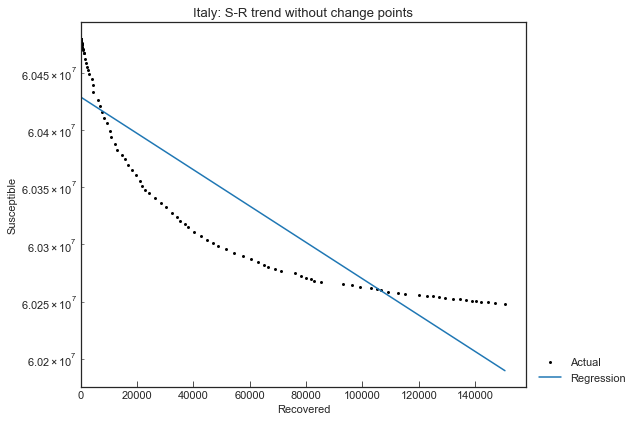

In [165]:
ita_scenario = cs.Scenario(jhu_data, pop_data, "Italy")
ita_scenario.trend()

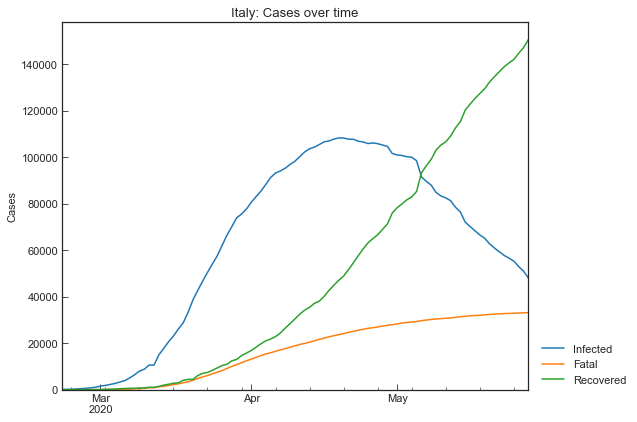

Date  Confirmed  Infected  Fatal  Recovered
114 2020-05-24     229858     56594  32785     140479
115 2020-05-25     230158     55300  32877     141981
116 2020-05-26     230555     52942  32955     144658
117 2020-05-27     231139     50966  33072     147101
118 2020-05-28     231732     47986  33142     150604

In [166]:
ita_scenario = cs.Scenario(jhu_data, pop_data, "Italy")
ita_scenario.records().tail()

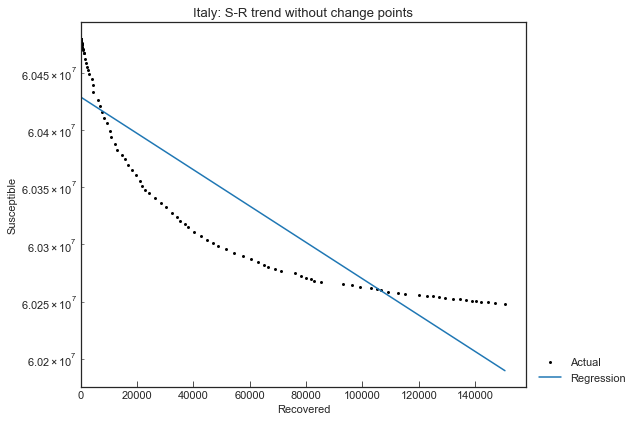

In [167]:
ita_scenario.trend()

Finding change points of S-R trend...
Finished 150 trials in 1 min 2 sec.c.


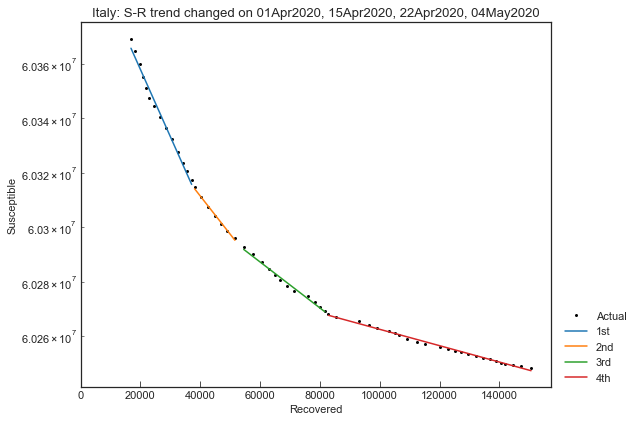

In [168]:
ita_scenario.trend(n_points=4)

In [169]:
ita_scenario.summary()


Type      Start        End  Population
1st  Past  01Apr2020  14Apr2020    60480000
2nd  Past  15Apr2020  21Apr2020    60480000
3rd  Past  22Apr2020  03May2020    60480000
4th  Past  04May2020  28May2020    60480000

In [170]:
ita_scenario.estimate(cs.SIRF)


1st phase with SIR-F model:
	Running optimization...
	Finished 373 trials in 1 min 16 sec..
2nd phase with SIR-F model:
	Running optimization...
	Finished 109 trials in 0 min 21 sec..
3rd phase with SIR-F model:
	Running optimization...
	Finished 352 trials in 1 min 16 sec..
4th phase with SIR-F model:
	Running optimization...
	Finished 55 trials in 0 min 10 sec..


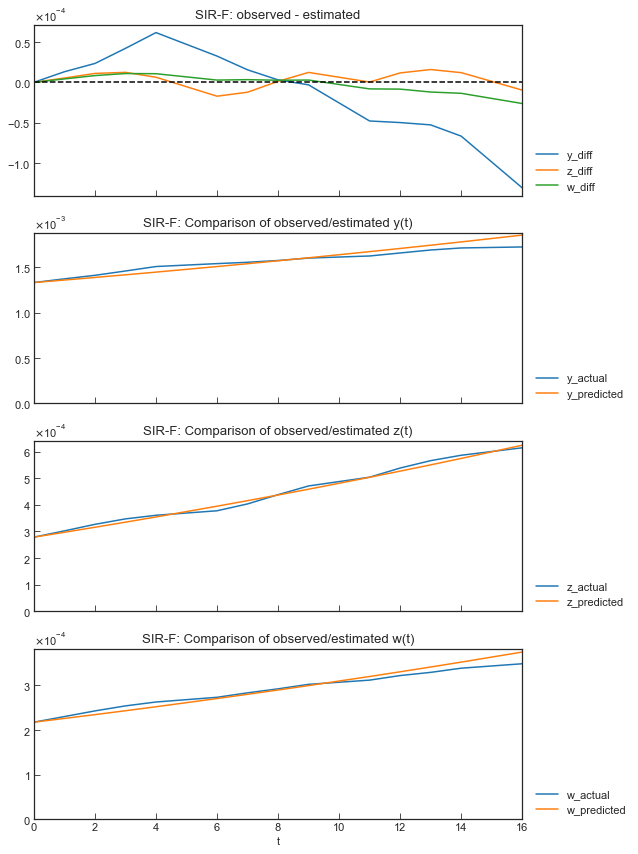

In [171]:
ita_scenario.estimate_accuracy(phase="1st")


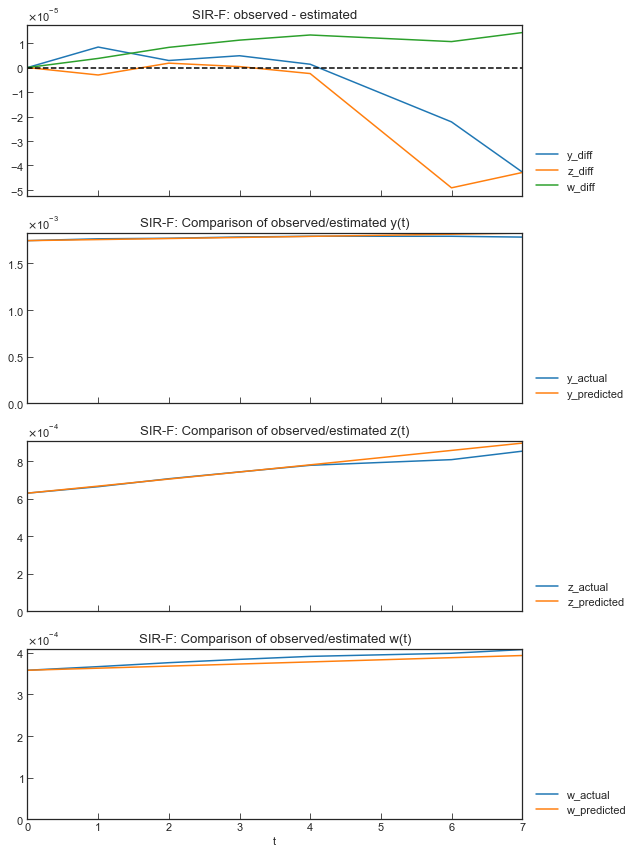

In [172]:
ita_scenario.estimate_accuracy(phase="2nd")


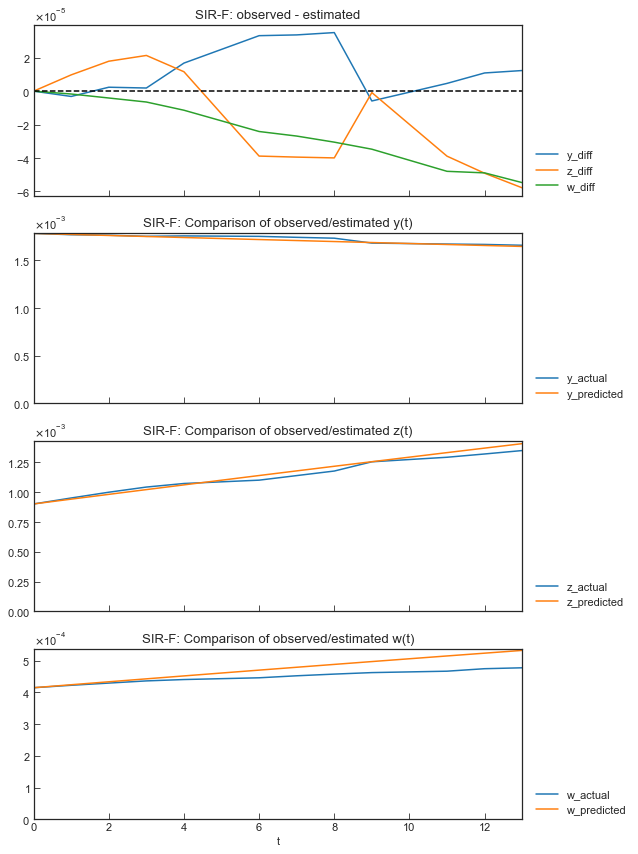

In [173]:
ita_scenario.estimate_accuracy(phase="3rd")

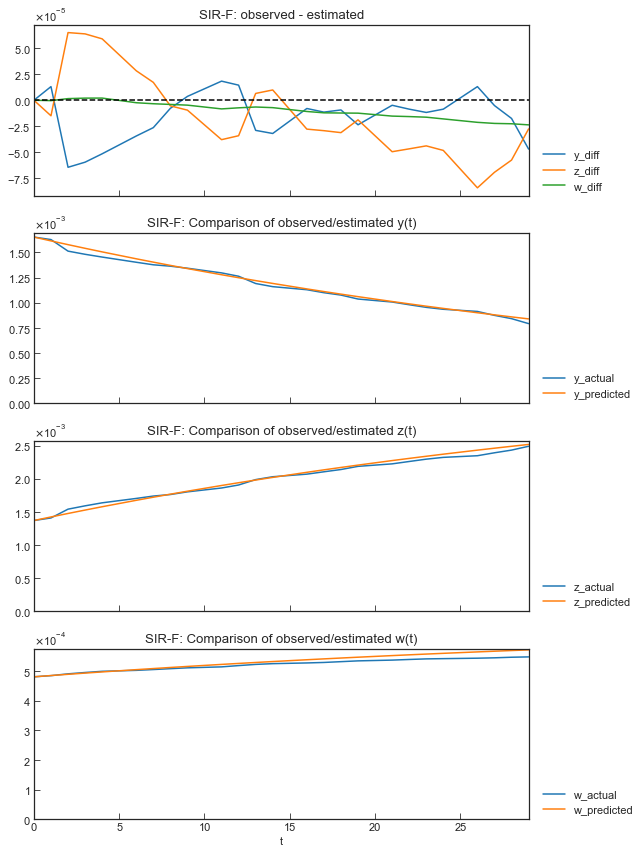

In [174]:
ita_scenario.estimate_accuracy(phase="4th")


In [175]:
ita_scenario.summary()


Type      Start        End  Population    ODE   tau     theta     kappa  \
1st  Past  01Apr2020  14Apr2020    60480000  SIR-F  1162  0.144249  0.000365   
2nd  Past  15Apr2020  21Apr2020    60480000  SIR-F  1162  0.026610  0.002020   
3rd  Past  22Apr2020  03May2020    60480000  SIR-F  1162  0.227286  0.000310   
4th  Past  04May2020  28May2020    60480000  SIR-F  1162  0.073450  0.001710   

          rho     sigma    Rt  alpha1 [-]  1/alpha2 [day]  1/beta [day]  \
1st  0.040649  0.013653  2.48       0.144            2209            19   
2nd  0.030707  0.021330  1.28       0.027             399            26   
3rd  0.021966  0.022750  0.74       0.227            2601            36   
4th  0.012257  0.032936  0.33       0.073             471            65   

     1/gamma [day]     RMSLE  Trials       Runtime  
1st             59  0.041523     373  1 min 16 sec  
2nd             37  0.023123     109  0 min 21 sec  
3rd             35  0.051999     352  1 min 16 sec  
4th             24  0.041444      55  0 min 10 sec

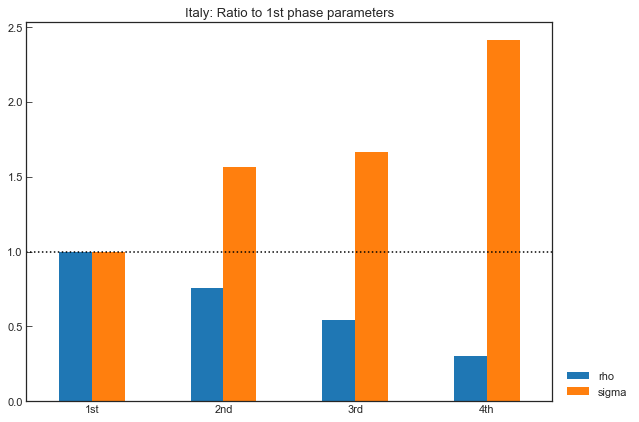

rho     sigma
1st  1.000000  1.000000
2nd  0.755419  1.562273
3rd  0.540377  1.666257
4th  0.301527  2.412322

In [176]:
ita_scenario.param_history(targets=["rho", "sigma"])

In [177]:
def _color(data_df):
    df = data_df.copy()
    df.loc[:, :] = str()
    df.iloc[[3, 6, 8], :] = "background-color: lightgreen"
    return df

ita_action_df.style.apply(_color, axis=None)

In [178]:
ita_scenario.get("Start", "3rd")


'22Apr2020'

In [179]:
c_before, c_after = 1.0, 0.81

In [180]:
ita_out_df = go_out("Italy")
ita_out_df

Age_first  Age_last     Period_of_life  School  Office  Others   Portion
0           0         2            nursery       3       0       0  0.023674
1           3         5     nursery school       4       0       1  0.024795
2           6        10  elementary school       5       0       1  0.045552
3          11        13      middle school       5       0       1  0.028506
4          14        18        high school       6       0       1  0.047546
5          19        25    university/work       3       3       1  0.068986
6          26        35               work       0       6       1  0.110560
7          36        45               work       0       5       1  0.137011
8          46        55               work       0       5       1  0.161104
9          56        65               work       0       5       1  0.135972
10         66        75            retired       0       0       4  0.110518
11         76        85            retired       0       0       3  0.076720
12         86        95            retired       0       0       2  0.029057

In [181]:
df = ita_out_df.copy()
gs_before = (df[["School", "Office", "Others"]].sum(axis=1) * df["Portion"]).sum()
print(f"{round(gs_before, 1)} days in a week susceptible people go out.")

5.6 days in a week susceptible people go out.


In [182]:
rho_before = ita_scenario.get("rho", "1st")
rho_after = ita_scenario.get("rho", "3rd")
gs_after = rho_after / rho_before / c_after * gs_before * c_before
print(f"{round(gs_after, 1)} days in a week susceptible people go out after lockdown.")

3.7 days in a week susceptible people go out after lockdown.


In [183]:
df = ita_out_df.copy()
df["School"] = 0
df.loc[df["Office"] > 0, "Office"] = 1
sum_so = (df[["School", "Office"]].sum(axis=1) * df["Portion"]).sum()
df.loc[df["Others"] > 0, "Others"] = round(gs_after - sum_so, 1)
ita_out_after_df = df.copy()
ita_out_after_df

Age_first  Age_last     Period_of_life  School  Office  Others   Portion
0           0         2            nursery       0       0     0.0  0.023674
1           3         5     nursery school       0       0     3.1  0.024795
2           6        10  elementary school       0       0     3.1  0.045552
3          11        13      middle school       0       0     3.1  0.028506
4          14        18        high school       0       0     3.1  0.047546
5          19        25    university/work       0       1     3.1  0.068986
6          26        35               work       0       1     3.1  0.110560
7          36        45               work       0       1     3.1  0.137011
8          46        55               work       0       1     3.1  0.161104
9          56        65               work       0       1     3.1  0.135972
10         66        75            retired       0       0     3.1  0.110518
11         76        85            retired       0       0     3.1  0.076720
12         86        95            retired       0       0     3.1  0.029057

In [184]:
df = ita_out_after_df.copy()
gs_after2 = (df[["School", "Office", "Others"]].sum(axis=1) * df["Portion"]).sum()
print(f"{round(gs_after2, 1)} days in a week susceptible people go out after lockdown.")

3.6 days in a week susceptible people go out after lockdown.


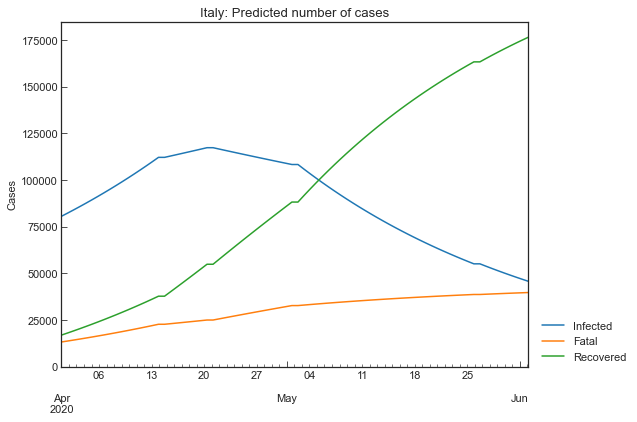

In [185]:
ita_scenario.clear()
ita_scenario.add_phase(days=7)
ita_scenario.predict().tail(7).style.background_gradient(axis=0)

In [186]:
ita_scenario.clear()
ita_scenario.add_phase(days=30)
ita_scenario.predict().tail(7).style.background_gradient(axis=0)

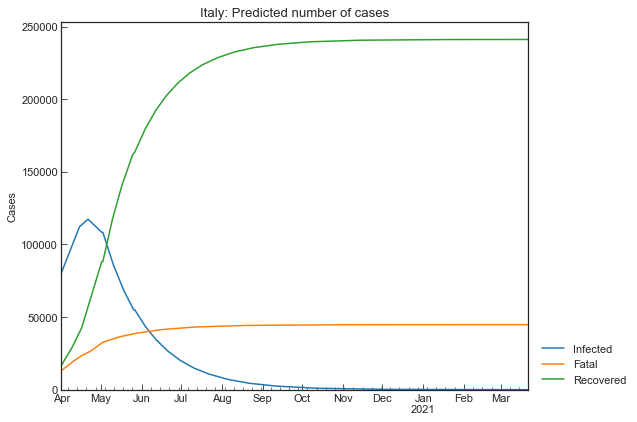

In [187]:
ita_scenario.clear()
ita_scenario.add_phase(days=300)
_ = ita_scenario.predict()

In [188]:
sigma_before = ita_scenario.get("sigma", "3rd")
kappa_before = ita_scenario.get("kappa", "3rd")
(sigma_before, kappa_before)

(0.02275005029285888, 0.00031012640887851913)

In [189]:
# Tentative evaluation with clinical study
sigma_med = ita_scenario.get("tau", "3rd") * (25 / 53) / ((10 + 18) * 1440)
kappa_med = ita_scenario.get("tau", "3rd") * (7 / 53) / ((10 + 18) * 1440)
(sigma_med, kappa_med)


(0.013594077568134173, 0.003806341719077568)

In [190]:
ita_scenario.clear()
ita_scenario.add_phase(days=90, kappa=kappa_med, sigma=sigma_med)
ita_scenario.predict().tail(7).style.background_gradient(axis=0)

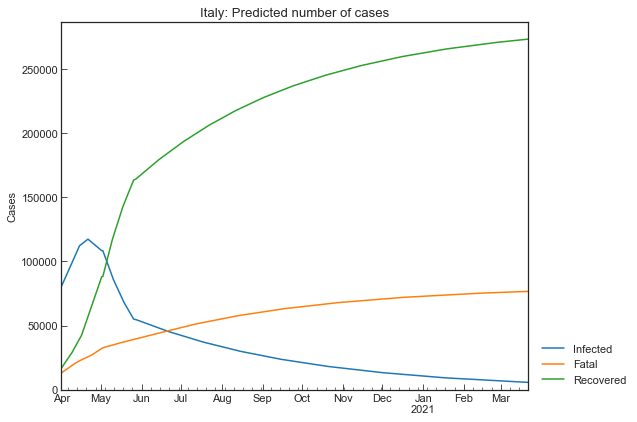

In [191]:
ita_scenario.clear()
ita_scenario.add_phase(days=300, kappa=kappa_med, sigma=sigma_med)
_ = ita_scenario.predict()

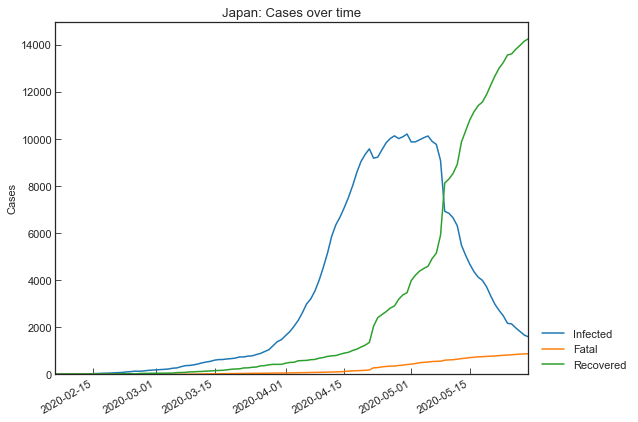

Date  Confirmed  Infected  Fatal  Recovered
104 2020-05-25      16581      2139    830      13612
105 2020-05-26      16623      1967    846      13810
106 2020-05-27      16651      1820    858      13973
107 2020-05-28      16683      1669    867      14147
108 2020-05-29      16719      1591    874      14254

In [192]:
jpn_scenario = cs.Scenario(jhu_data, pop_data, "Japan")
jpn_scenario.records().tail()

# S-R Trend analysis

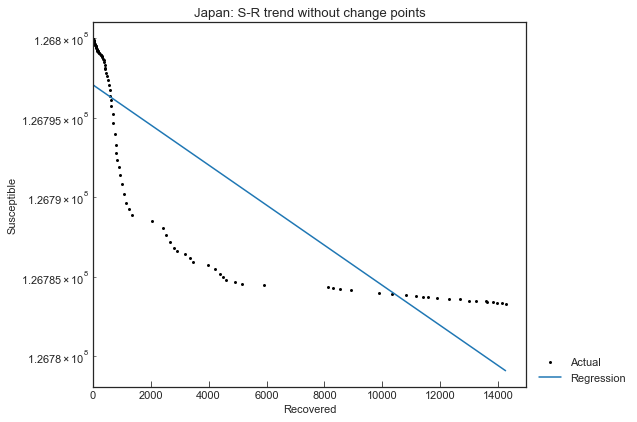

In [193]:
jpn_scenario.trend()

Finding change points of S-R trend...
Finished 150 trials in 0 min 46 sec..


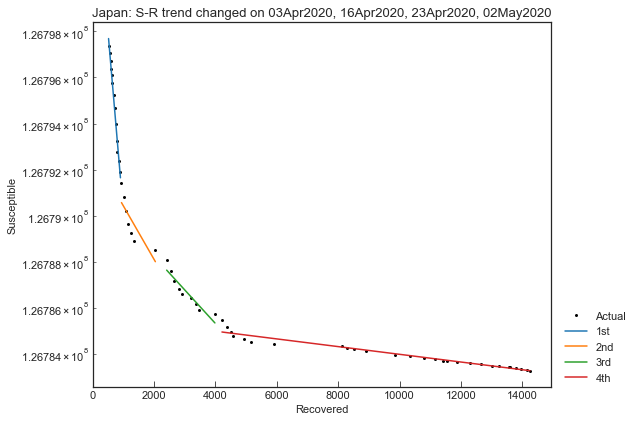

In [194]:
jpn_scenario.trend(n_points=4)

# Phase in Japan

In [195]:
jpn_scenario.summary()

Type      Start        End  Population
1st  Past  03Apr2020  15Apr2020   126800000
2nd  Past  16Apr2020  22Apr2020   126800000
3rd  Past  23Apr2020  01May2020   126800000
4th  Past  02May2020  29May2020   126800000

In [196]:
jpn_scenario.estimate(cs.SIRF)

1st phase with SIR-F model:
	Running optimization...
	Finished 411 trials in 1 min 14 sec..
2nd phase with SIR-F model:
	Running optimization...
	Finished 883 trials in 3 min 4 sec.c.
3rd phase with SIR-F model:
	Running optimization...
	Finished 108 trials in 0 min 21 sec..
4th phase with SIR-F model:
	Running optimization...
	Finished 108 trials in 0 min 21 sec..


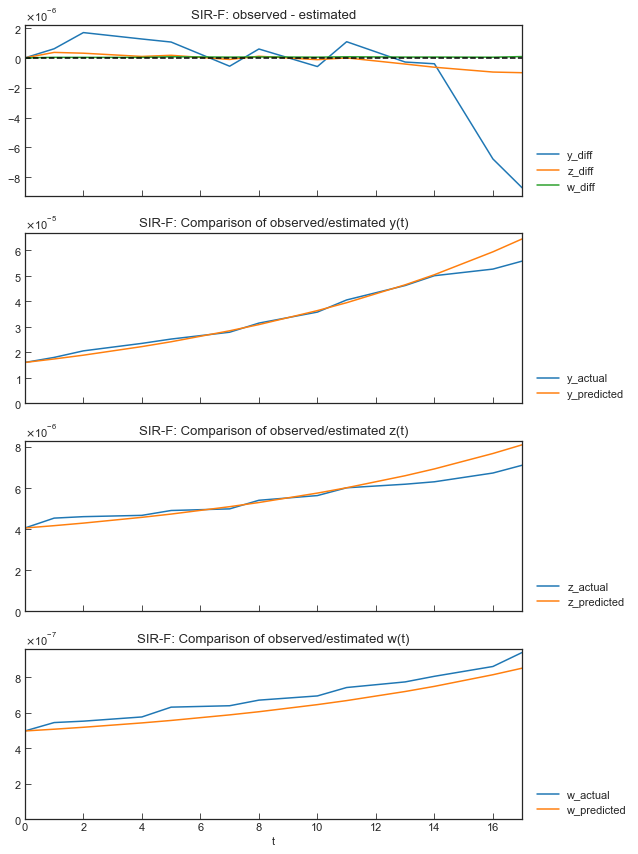

In [197]:
jpn_scenario.estimate_accuracy(phase="1st")

# 2nd phase

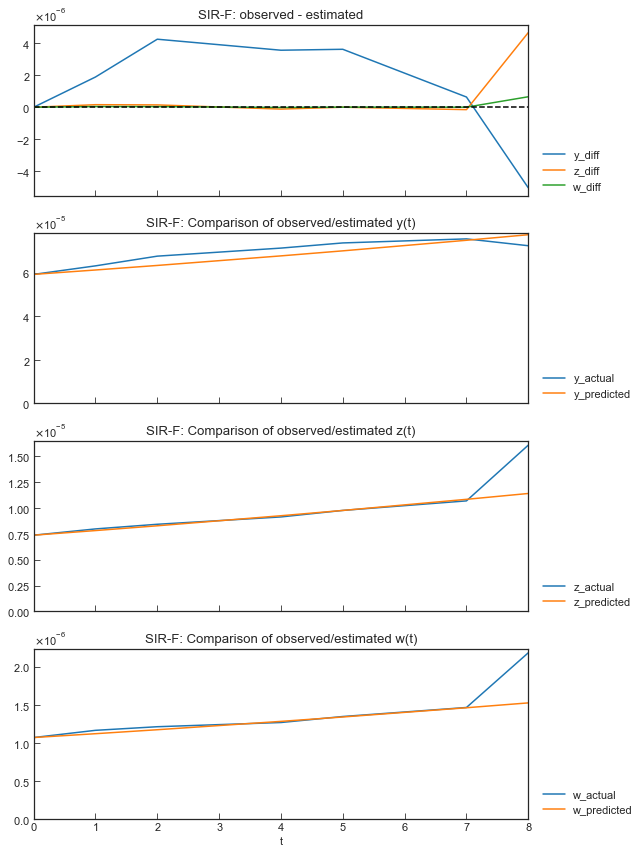

In [198]:
jpn_scenario.estimate_accuracy(phase="2nd")

# 3rd phase

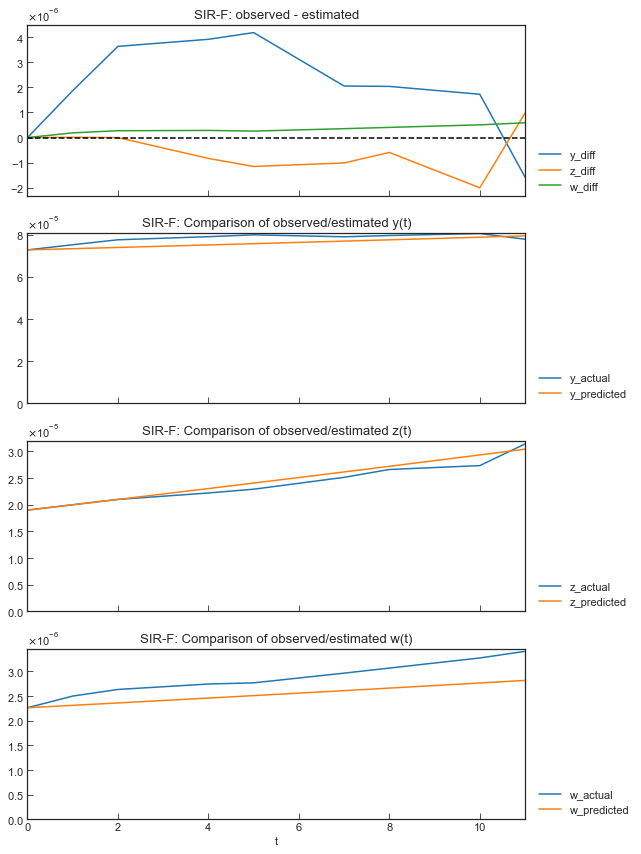

In [199]:
jpn_scenario.estimate_accuracy(phase="3rd")

# 4th phase

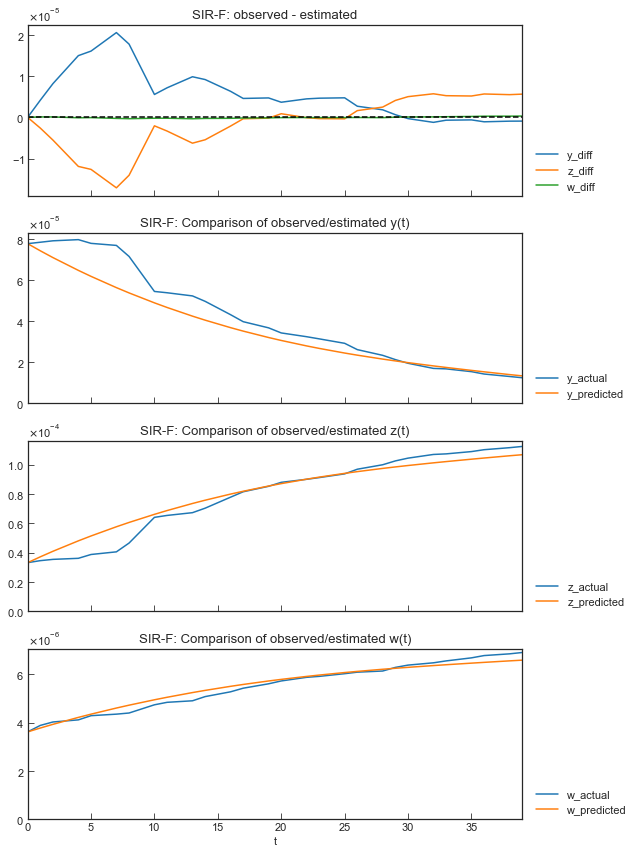

In [200]:
jpn_scenario.estimate_accuracy(phase="4th")

In [201]:
jpn_scenario.summary()

Type      Start        End  Population    ODE  tau     theta     kappa  \
1st  Past  03Apr2020  15Apr2020   126800000  SIR-F  977  0.000304  0.000569   
2nd  Past  16Apr2020  22Apr2020   126800000  SIR-F  977  0.000104  0.000832   
3rd  Past  23Apr2020  01May2020   126800000  SIR-F  977  0.008433  0.000475   
4th  Past  02May2020  29May2020   126800000  SIR-F  977  0.105695  0.001196   

          rho     sigma     Rt  alpha1 [-]  1/alpha2 [day]  1/beta [day]  \
1st  0.089140  0.006823  12.05       0.000            1192             7   
2nd  0.041765  0.007427   5.06       0.000             815            16   
3rd  0.022287  0.013664   1.56       0.008            1429            30   
4th  0.008596  0.052218   0.14       0.106             567            78   

     1/gamma [day]     RMSLE  Trials       Runtime  
1st             99  0.100017     411  1 min 14 sec  
2nd             91  0.112244     883   3 min 4 sec  
3rd             49  0.088325     108  0 min 21 sec  
4th             12  0.222348     108  0 min 21 sec

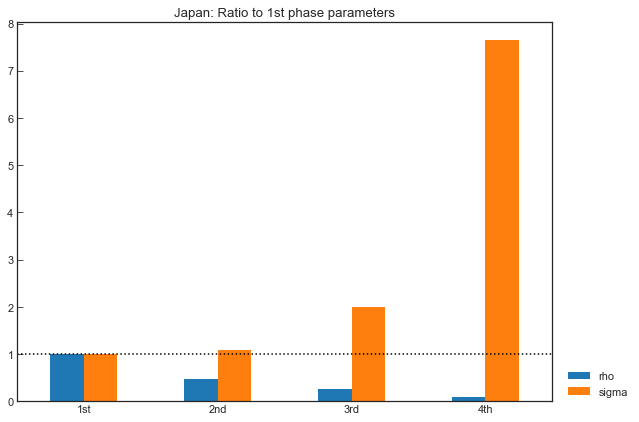

In [202]:
_ = jpn_scenario.param_history(targets=["rho", "sigma"])

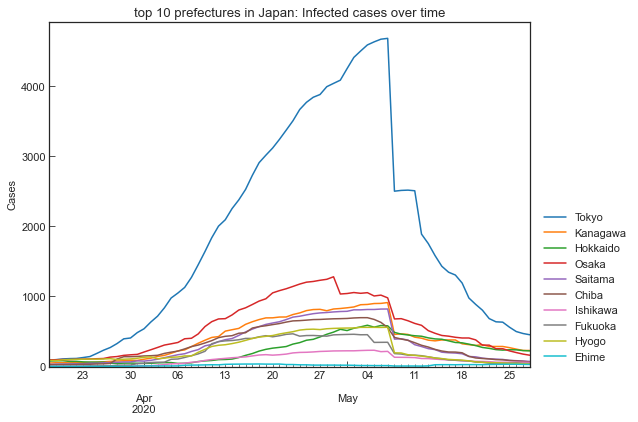

In [203]:
df = jpn_pref_df.copy()
df["Infected"] = df["Positive"] - df["Discharged"] - df["Fatal"]
df = df.pivot_table(
    index="Date", columns="Prefecture", values="Infected", aggfunc="last"
)
jpn_i_df = df.sort_values(by=df.index[-1], axis=1, ascending=False)
cs.line_plot(
    jpn_i_df.iloc[:, :10],
    "top 10 prefectures in Japan: Infected cases over time",
    y_integer=True
)

In [204]:
df = jpn_i_df.idxmax(axis=1)
df = df[df != df.shift()].reset_index()
df.columns = ["Start_date", "Where_highest"]
df

Start_date Where_highest
0 2020-03-18         Aichi
1 2020-03-23         Tokyo

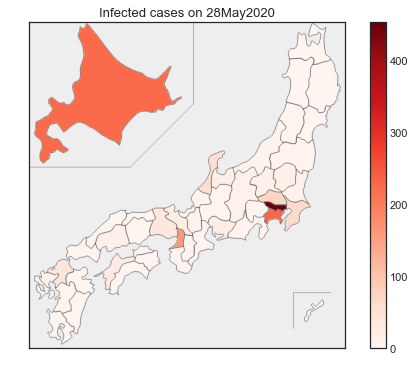

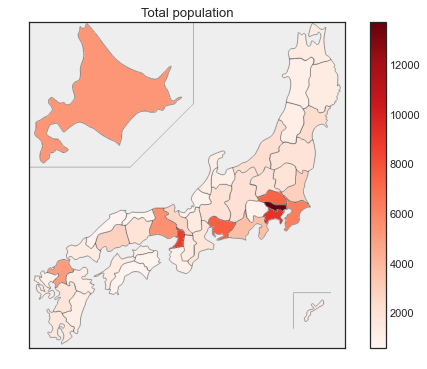

In [205]:
_date = jpn_i_df.index[-1].strftime("%d%b%Y")
df = pd.merge(
    jpn_meta_df[["Population_Total", "Area_Habitable"]],
    jpn_i_df.loc[jpn_i_df.index[-1], :],
    left_index=True, right_index=True
)
df.columns = ["Population", "Area", "Infected"]
df["Density"] = df["Population"] / df["Area"]
df["I_rate"] = df["Infected"] / df["Population"]
cs.jpn_map(df.index, df["Infected"], f"Infected cases on {_date}")
cs.jpn_map(df.index, df["Population"], f"Total population")

In [206]:
jpn_scenario.get("sigma", "2nd") / jpn_scenario.get("sigma", "1st")

1.088507856096411

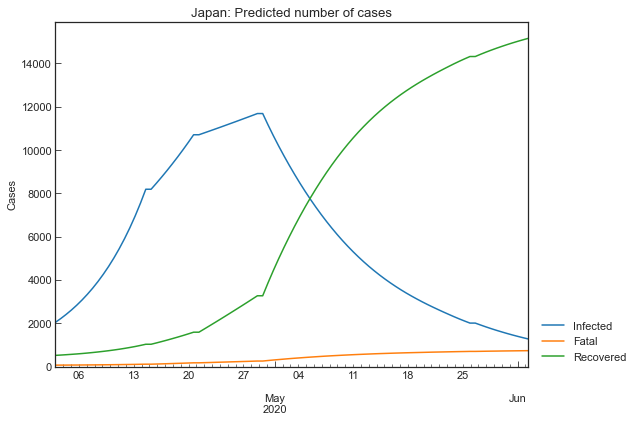

In [207]:
jpn_scenario.clear()
jpn_scenario.add_phase(days=7)
jpn_scenario.predict().tail(7).style.background_gradient(axis=0)

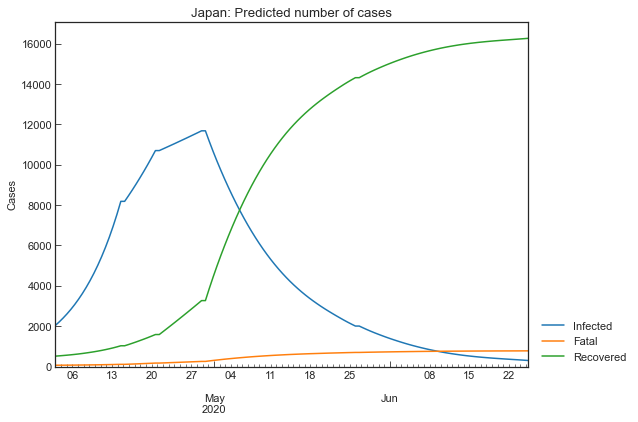

In [208]:
jpn_scenario.clear()
jpn_scenario.add_phase(days=30)
jpn_scenario.predict().tail(7).style.background_gradient(axis=0)

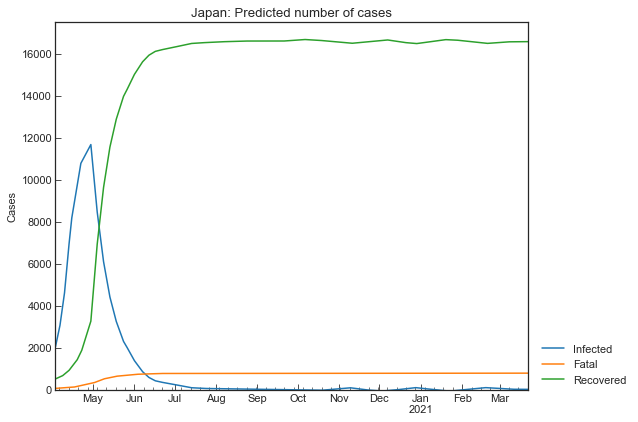

In [209]:
jpn_scenario.clear()
jpn_scenario.add_phase(days=300)
_ = jpn_scenario.predict()

In [210]:
df = jpn_scenario.records(show_figure=False)
1 - df.iloc[-1, :]["Confirmed"] / pop_data.value("Japan")

0.9998681466876972

In [211]:
jpn_scenario.get("Rt", "2nd")

5.06

In [212]:
jpn_scenario.clear()
jpn_scenario.add_phase(days=1000)
df = jpn_scenario.predict(show_figure=False)
df.loc[df["Infected"].idxmax(), "Date"].strftime("%d%b%Y")

'28Apr2020'

In [213]:
current_rho = jpn_scenario.get("rho", "last")
limit_rho = current_rho / jpn_scenario.get("Rt", "last") * 1.0
limit_rho

0.061402270689622826

In [214]:
beta_inv = math.ceil(jpn_scenario.get("tau", "last") / 24 / 60 / limit_rho) + 1
target_rho = jpn_scenario.get("tau", "last") / 24 / 60 / beta_inv
target_rho

0.05219017094017094

In [215]:
target_rho < limit_rho

True

In [216]:
jpn_scenario.clear()
jpn_scenario.add_phase("30Jun2020", rho=target_rho)
jpn_scenario.summary()

Type      Start        End  Population    ODE  tau     theta     kappa  \
1st    Past  03Apr2020  15Apr2020   126800000  SIR-F  977  0.000304  0.000569   
2nd    Past  16Apr2020  22Apr2020   126800000  SIR-F  977  0.000104  0.000832   
3rd    Past  23Apr2020  01May2020   126800000  SIR-F  977  0.008433  0.000475   
4th    Past  02May2020  29May2020   126800000  SIR-F  977  0.105695  0.001196   
5th  Future  30May2020  30Jun2020   126800000  SIR-F  977  0.105695  0.001196   

          rho     sigma     Rt  alpha1 [-]  1/alpha2 [day]  1/beta [day]  \
1st  0.089140  0.006823  12.05       0.000            1192             7   
2nd  0.041765  0.007427   5.06       0.000             815            16   
3rd  0.022287  0.013664   1.56       0.008            1429            30   
4th  0.008596  0.052218   0.14       0.106             567            78   
5th  0.052190  0.052218   0.87       0.106             567            13   

     1/gamma [day]      RMSLE Trials       Runtime  
1st             99   0.100017    411  1 min 14 sec  
2nd             91   0.112244    883   3 min 4 sec  
3rd             49  0.0883246    108  0 min 21 sec  
4th             12   0.222348    108  0 min 21 sec  
5th             12          -      -             -

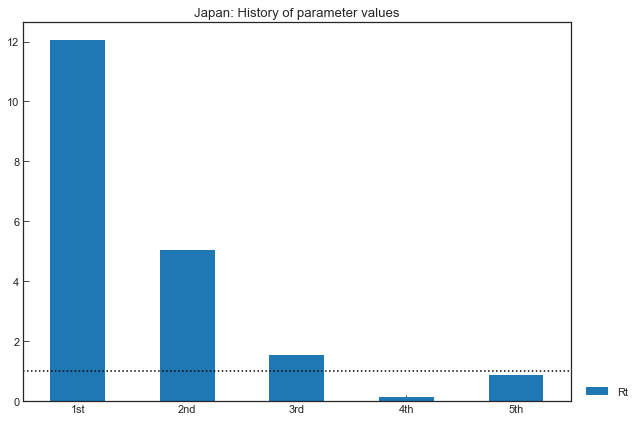

In [217]:
_ = jpn_scenario.param_history(targets=["Rt"], divide_by_first=False)

In [218]:
jpn_scenario.clear()
jpn_scenario.add_phase(days=100, rho=target_rho)
df = jpn_scenario.predict(show_figure=False)
df.loc[df["Infected"].idxmax(), "Date"].strftime("%d%b%Y")

'28Apr2020'

# Scenario in India

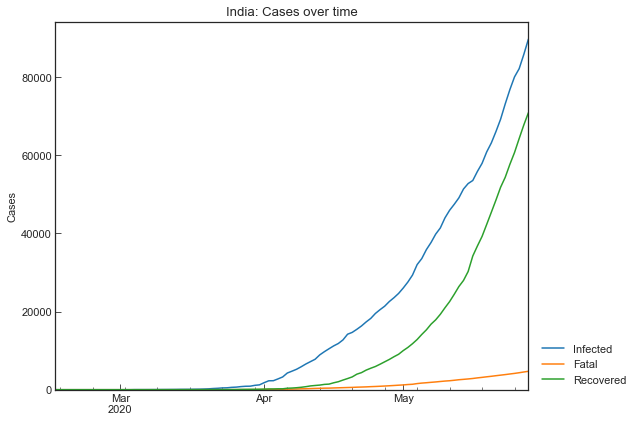

Date  Confirmed  Infected  Fatal  Recovered
115 2020-05-24     138536     76820   4024      57692
116 2020-05-25     144950     80072   4172      60706
117 2020-05-26     150793     82172   4344      64277
118 2020-05-27     158086     85803   4534      67749
119 2020-05-28     165386     89755   4711      70920

In [219]:
ind_scenario = cs.Scenario(jhu_data, pop_data, "India")
ind_scenario.records().tail()

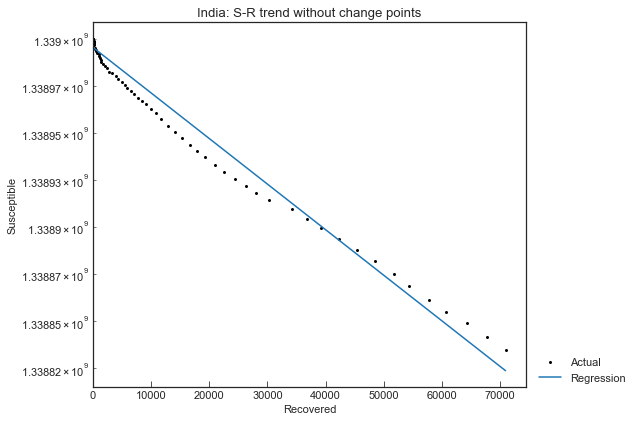

In [220]:
ind_scenario.trend()

Finding change points of S-R trend...
Finished 90 trials in 0 min 24 sec..


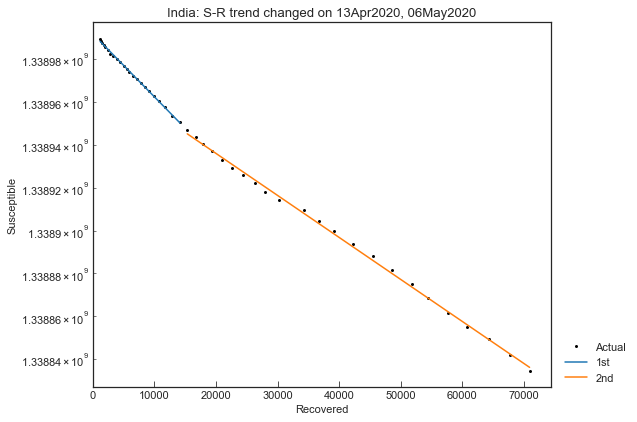

In [221]:
ind_scenario.trend(n_points=2)

In [222]:
ind_scenario.summary()

Type      Start        End  Population
1st  Past  13Apr2020  05May2020  1339000000
2nd  Past  06May2020  28May2020  1339000000

In [223]:
ind_scenario.estimate(cs.SIRF)

1st phase with SIR-F model:
	Running optimization...
	Finished 457 trials in 3 min 2 sec.c.
2nd phase with SIR-F model:
	Running optimization...
	Finished 712 trials in 3 min 7 sec.c.


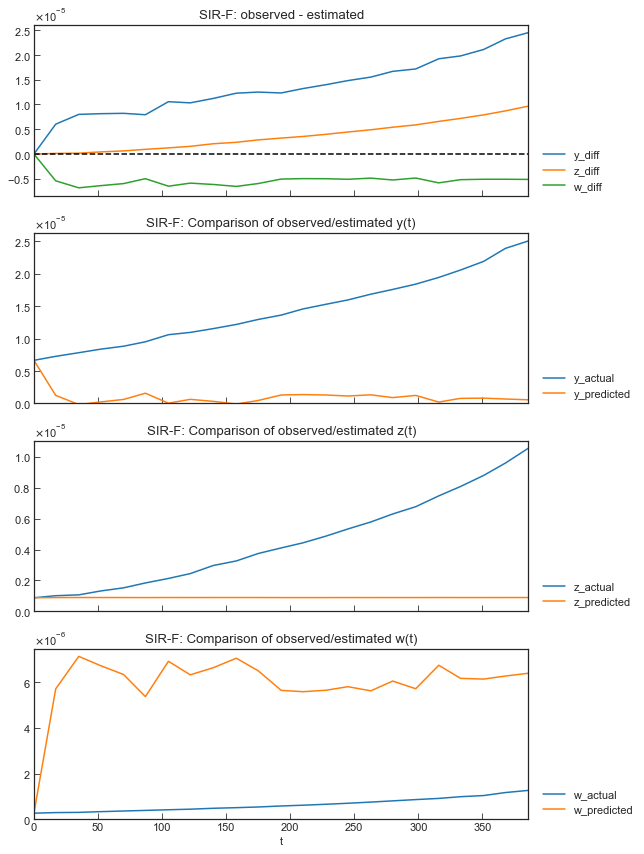

In [224]:
ind_scenario.estimate_accuracy(phase="1st")

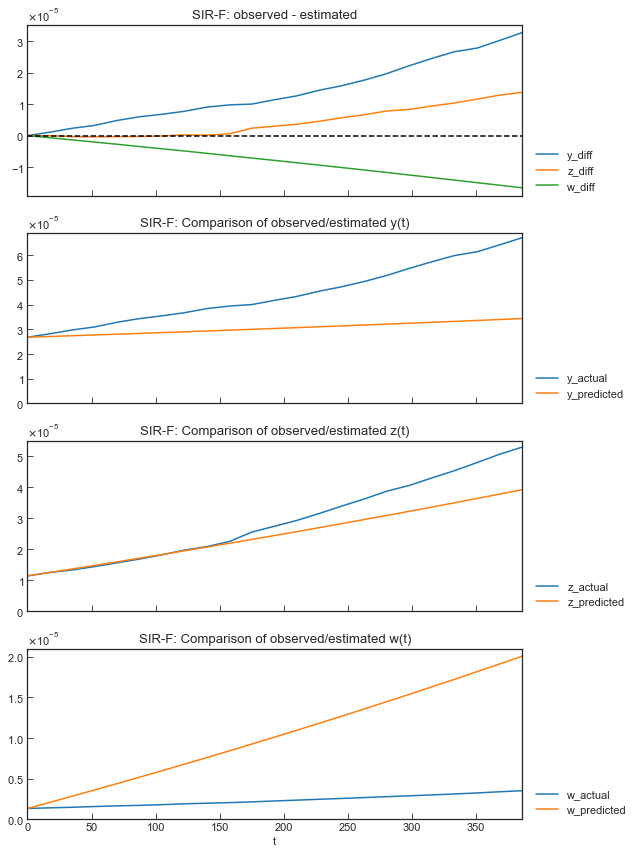

In [225]:
ind_scenario.estimate_accuracy(phase="2nd")

In [226]:
ind_scenario.summary()

Type      Start        End  Population    ODE  tau     theta     kappa  \
1st  Past  13Apr2020  05May2020  1339000000  SIR-F   82  0.498033  0.753057   
2nd  Past  06May2020  28May2020  1339000000  SIR-F   82  0.342581  0.000019   

          rho     sigma    Rt  alpha1 [-]  1/alpha2 [day]  1/beta [day]  \
1st  0.005461  0.001730  0.00       0.498               0            10   
2nd  0.004607  0.002366  1.27       0.343            3055            12   

     1/gamma [day]     RMSLE  Trials      Runtime  
1st             32  4.142682     457  3 min 2 sec  
2nd             24  1.521750     712  3 min 7 sec

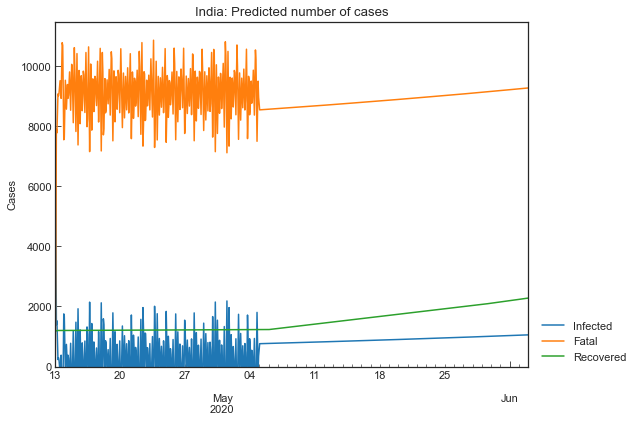

In [227]:
ind_scenario.clear()
ind_scenario.add_phase(days=7)
ind_scenario.predict().tail(7).style.background_gradient(axis=0)

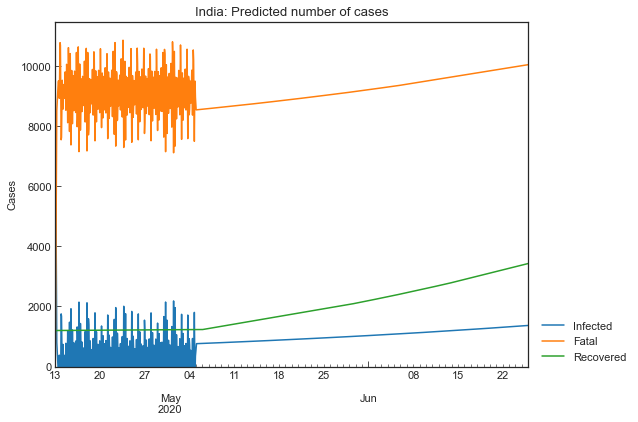

In [228]:
ind_scenario.clear()
ind_scenario.add_phase(days=30)
ind_scenario.predict().tail(7).style.background_gradient(axis=0)

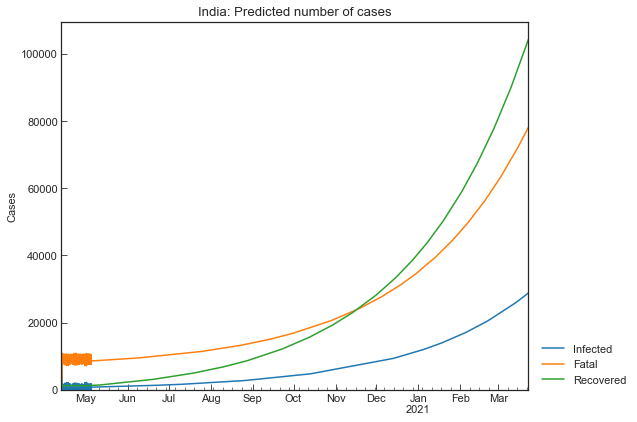

In [229]:
ind_scenario.clear()
ind_scenario.add_phase(days=300)
_ = ind_scenario.predict()

# Scenario in USA

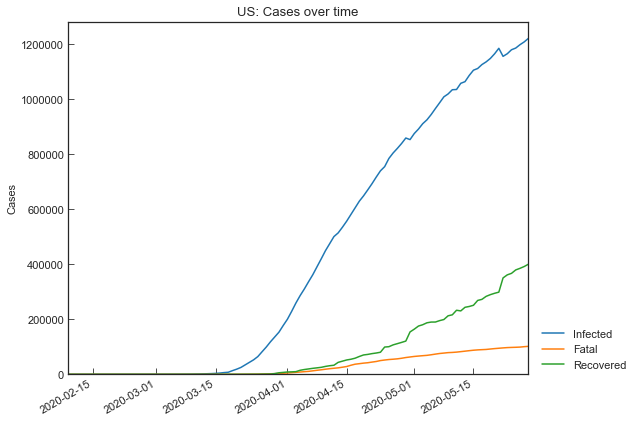

Date  Confirmed  Infected   Fatal  Recovered
123 2020-05-24    1643246   1178790   97720     366736
124 2020-05-25    1662302   1184925   98220     379157
125 2020-05-26    1680913   1197098   98913     384902
126 2020-05-27    1699176   1207250  100418     391508
127 2020-05-28    1721753   1220146  101616     399991

In [230]:
usa_scenario = cs.Scenario(jhu_data, pop_data, "US")
usa_scenario.records().tail()

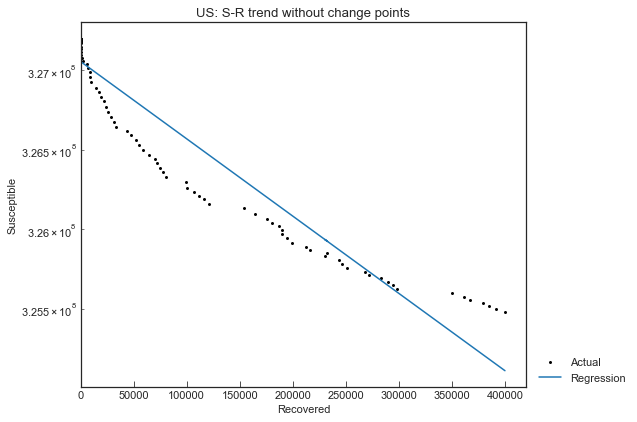

In [231]:
_ = usa_scenario.trend()

Finding change points of S-R trend...


C:\Users\alshrooq\Anaconda3\lib\site-packages\covsirphy\phase\trend.py:124: RuntimeWarning: divide by zero encountered in log10
  np.log10(actual + 1) - np.log10(predicted + 1)
C:\Users\alshrooq\Anaconda3\lib\site-packages\covsirphy\phase\trend.py:124: RuntimeWarning: invalid value encountered in log10
  np.log10(actual + 1) - np.log10(predicted + 1)


Finished 90 trials in 0 min 54 sec..


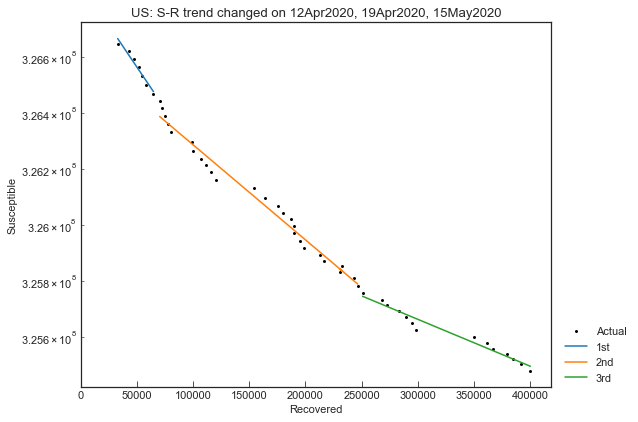

In [232]:
usa_scenario.trend(n_points=3)

In [233]:
usa_scenario.summary()

Type      Start        End  Population
1st  Past  12Apr2020  18Apr2020   327200000
2nd  Past  19Apr2020  14May2020   327200000
3rd  Past  15May2020  28May2020   327200000

In [234]:
usa_scenario.estimate(cs.SIRF)

1st phase with SIR-F model:
	Running optimization...
	Finished 167 trials in 0 min 44 sec..
2nd phase with SIR-F model:
	Running optimization...
	Finished 182 trials in 0 min 43 sec..
3rd phase with SIR-F model:
	Running optimization...
	Finished 179 trials in 0 min 43 sec..


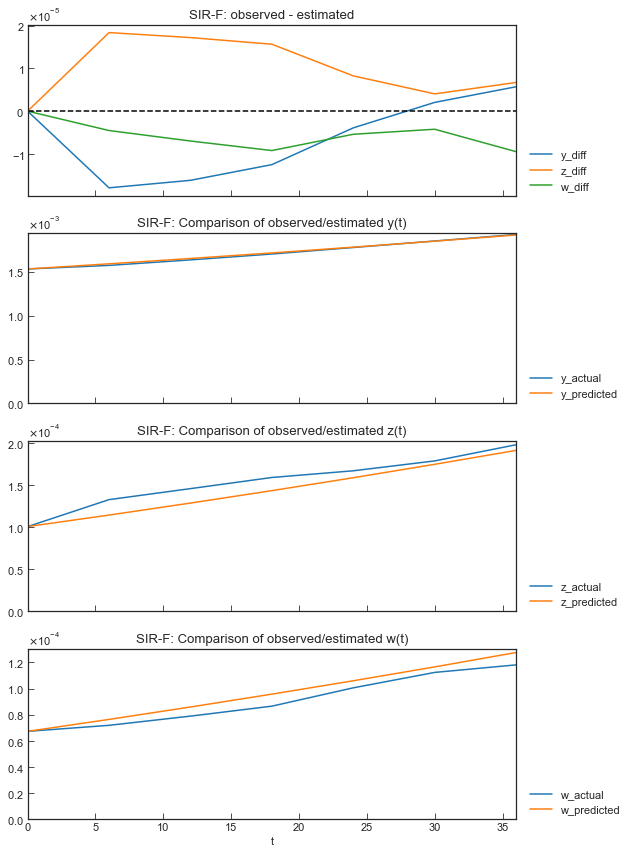

In [235]:
usa_scenario.estimate_accuracy(phase="1st")

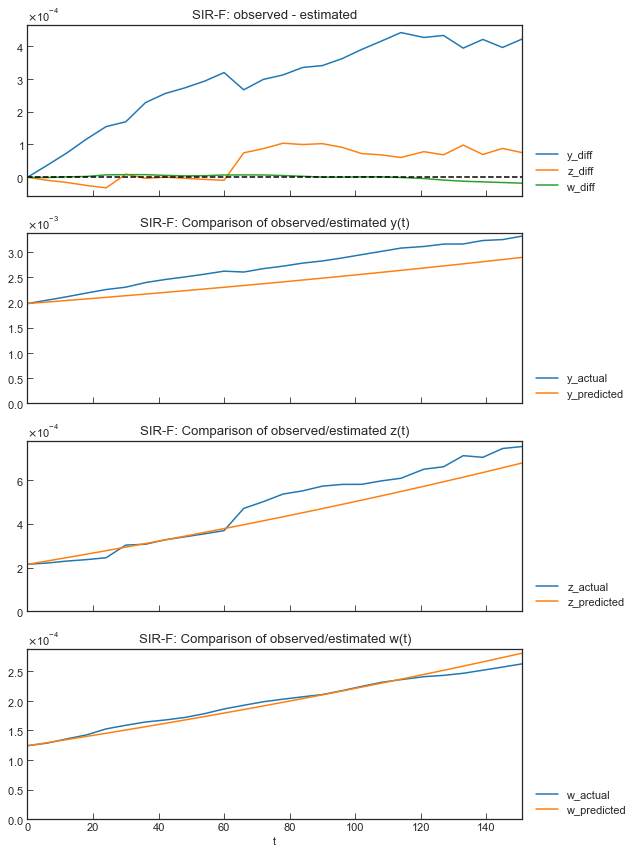

In [236]:
usa_scenario.estimate_accuracy(phase="2nd")

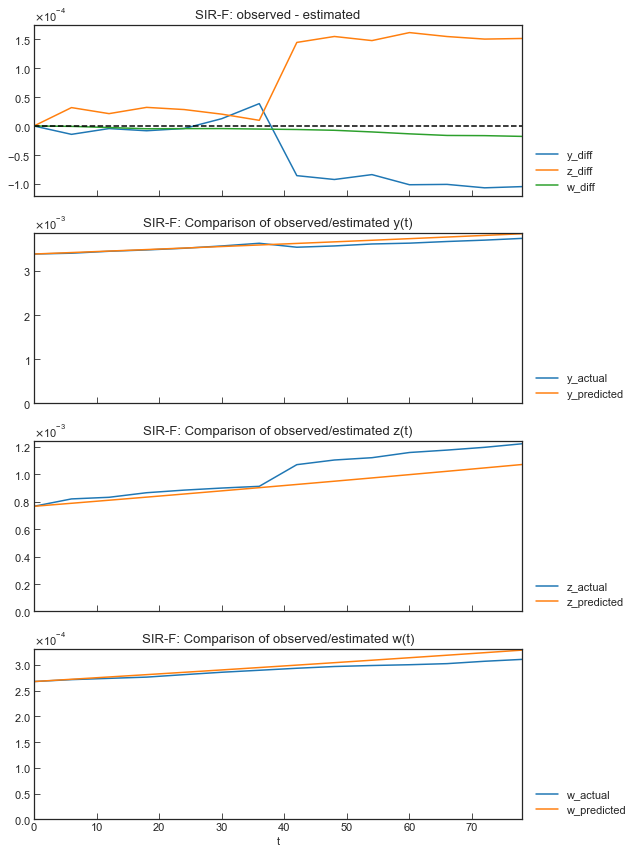

In [237]:
usa_scenario.estimate_accuracy(phase="3rd")

In [238]:
usa_scenario.summary()

Type      Start        End  Population    ODE  tau     theta     kappa  \
1st  Past  12Apr2020  18Apr2020   327200000  SIR-F  238  0.109495  0.000024   
2nd  Past  19Apr2020  14May2020   327200000  SIR-F  238  0.056677  0.000191   
3rd  Past  15May2020  28May2020   327200000  SIR-F  238  0.015403  0.000172   

          rho     sigma    Rt  alpha1 [-]  1/alpha2 [day]  1/beta [day]  \
1st  0.008725  0.001468  5.21       0.109            6947            18   
2nd  0.004230  0.001273  2.73       0.057             867            39   
3rd  0.002949  0.001086  2.31       0.015             959            56   

     1/gamma [day]     RMSLE  Trials       Runtime  
1st            112  0.062981     167  0 min 44 sec  
2nd            129  0.190839     182  0 min 43 sec  
3rd            152  0.088474     179  0 min 43 sec

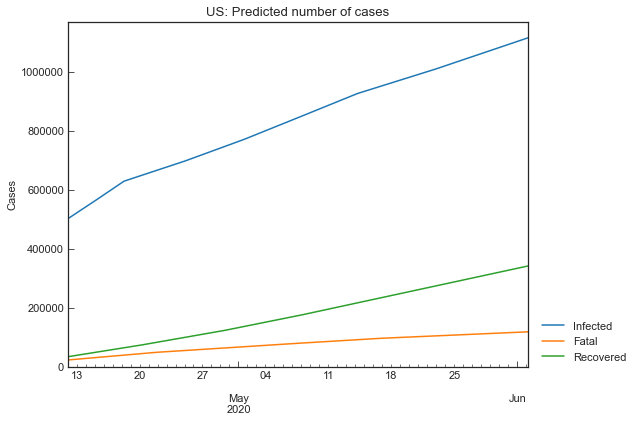

In [242]:
usa_scenario.clear()
usa_scenario.add_phase(days=7)
usa_scenario.predict().tail(7).style.background_gradient(axis=0)

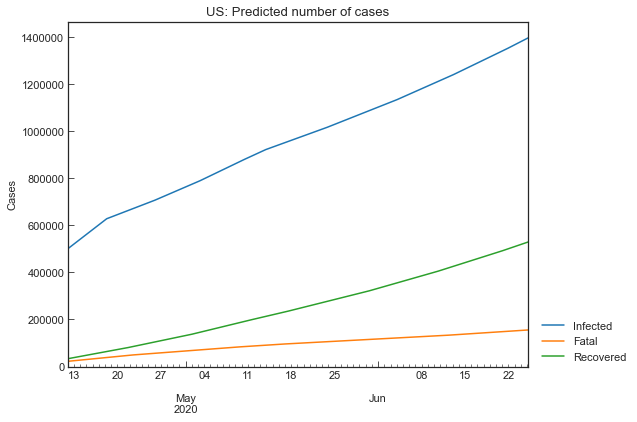

In [243]:
usa_scenario.clear()
usa_scenario.add_phase(days=30)
usa_scenario.predict().tail(7).style.background_gradient(axis=0)

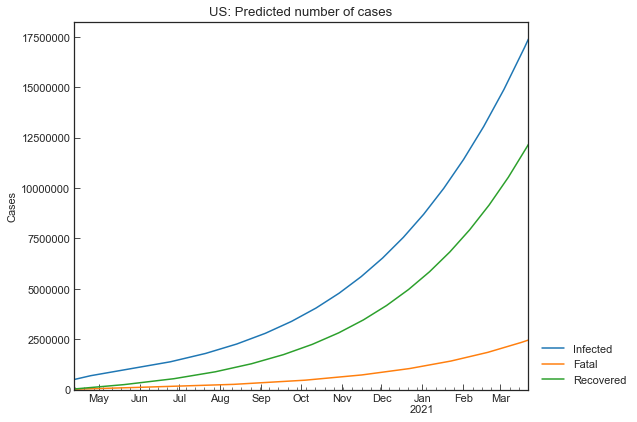

In [244]:
usa_scenario.clear()
usa_scenario.add_phase(days=300)
_ = usa_scenario.predict()